In [1]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import time
import warnings
import seaborn as sns
import math

In [2]:
from nltk.corpus import stopwords
from collections import Counter, defaultdict

In [3]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

In [4]:
from mlxtend.classifier import StackingClassifier
from imblearn.over_sampling import SMOTE
from scipy.sparse import hstack
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [5]:
#loading training variants. data separated by comma
data_variants = pd.read_csv('training/training_variants')

In [6]:
#loading training text dataset. data separated by ||
data_text = pd.read_csv("training/training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)

In [7]:
data_variants.head(15)

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4
5,5,CBL,V391I,4
6,6,CBL,V430M,5
7,7,CBL,Deletion,1
8,8,CBL,Y371H,4
9,9,CBL,C384R,4


In [8]:
data_variants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 4 columns):
ID           3321 non-null int64
Gene         3321 non-null object
Variation    3321 non-null object
Class        3321 non-null int64
dtypes: int64(2), object(2)
memory usage: 103.9+ KB


In [9]:
data_variants.describe()

,ID,Class
count,3321.000000,3321.000000
mean,1660.000000,4.365854
std,958.834449,2.309781
min,0.000000,1.000000
25%,830.000000,2.000000
50%,1660.000000,4.000000
75%,2490.000000,7.000000
max,3320.000000,9.000000


In [10]:
data_variants.shape

(3321, 4)

In [11]:
data_variants.columns

Index(['ID', 'Gene', 'Variation', 'Class'], dtype='object')

In [12]:
data_text.head(20)

,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...
5,5,Oncogenic mutations in the monomeric Casitas B...
6,6,Oncogenic mutations in the monomeric Casitas B...
7,7,CBL is a negative regulator of activated recep...
8,8,Abstract Juvenile myelomonocytic leukemia (JM...
9,9,Abstract Juvenile myelomonocytic leukemia (JM...


In [13]:
data_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 2 columns):
ID      3321 non-null int64
TEXT    3316 non-null object
dtypes: int64(1), object(1)
memory usage: 52.0+ KB


In [14]:
data_text.describe()

,ID
count,3321.000000
mean,1660.000000
std,958.834449
min,0.000000
25%,830.000000
50%,1660.000000
75%,2490.000000
max,3320.000000


In [15]:
data_text.shape

(3321, 2)

In [16]:
data_text.columns

Index(['ID', 'TEXT'], dtype='object')

In [17]:
data_variants.Class.unique()

array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [18]:
#we would like to remove all stop words like a, an, the, is, ...
#sp we are collecting from nltk library
stop_words = set(stopwords.words('english'))

In [19]:
def data_text_preprocess(total_text, ind, col):
    
    #remove int values from txt data for being of lpow importance
    if type(total_text) is not int:
        string = ""
        
        #replacing all special character with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', str(total_text))
        
        #replaacing multiple spaces with single space
        total_text = re.sub('\s+', ' ', str(total_text))
        
        #bring whole text to same lower case 
        total_text = total_text.lower()
        
        for word in total_text.split():
            #if the word is not a stopword then retain the word from text
            if not word in stop_words:
                string += word + " "
         
        data_text[col][ind] = string

In [20]:
for index, row in data_text.iterrows():
    if type(row['TEXT']) is str:
        data_text_preprocess(row['TEXT'],index,'TEXT')

In both the datasets, ID was a common column. So it can be used t0 merge the two datasets.

In [21]:
#merging both gene variations and text data based on ID
result = pd.merge(data_variants, data_text, on = 'ID', how = 'left')
result.head(20)

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...
5,5,CBL,V391I,4,oncogenic mutations monomeric casitas b lineag...
6,6,CBL,V430M,5,oncogenic mutations monomeric casitas b lineag...
7,7,CBL,Deletion,1,cbl negative regulator activated receptor tyro...
8,8,CBL,Y371H,4,abstract juvenile myelomonocytic leukemia jmml...
9,9,CBL,C384R,4,abstract juvenile myelomonocytic leukemia jmml...


In [22]:
#looking for missing data
result[result.isnull().any(axis = 1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [23]:
# we can replace the NaN(not any number) by adding some text.
result.loc[result['TEXT'].isnull(), 'TEXT'] = result['Gene'] + ' ' + result["Variation"]

#cross-checking
result[result.isnull().any(axis = 1)]

,ID,Gene,Variation,Class,TEXT


### Creating training, test and validation datasets

In [24]:
#before splitting, we should ensure that all the spaces in Gene and Variation column are replace by '_'

y_true = result['Class'].values
result.Gene = result.Gene.str.replace('\s+','_')
result.Variation = result.Variation.str.replace('\s+','_')

In [25]:
#splitting the data into train and test sets
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify = y_true, test_size = 0.2)

#splitting the training(earlier) set into train(new) and cross_validation sets
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify = y_train, test_size = 0.2)

In [26]:
print('Number of data points in the training set: {}'.format(train_df.shape[0]))
print('Number of data points in the test set: {}'.format(test_df.shape[0]))
print('Number of data points in the cross-validation set: {}'.format(cv_df.shape[0]))

Number of data points in the training set: 2124
Number of data points in the test set: 665
Number of data points in the cross-validation set: 532


In [28]:
class_distribution = result['Class'].value_counts().sort_index()
train_class_distribution = train_df['Class'].value_counts().sort_index()
test_class_distribution = test_df['Class'].value_counts().sort_index()
cv_class_distribution = cv_df['Class'].value_counts().sort_index()

In [29]:
class_distribution

1    568
2    452
3     89
4    686
5    242
6    275
7    953
8     19
9     37
Name: Class, dtype: int64

Current size: [6.0, 4.0]


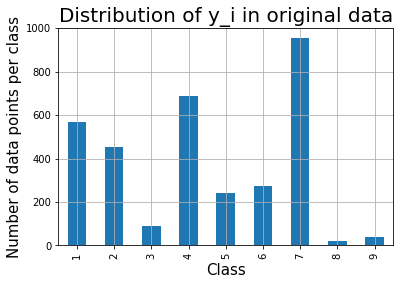

In [30]:
my_colors = 'rgbkymc'
class_distribution.plot(kind = 'bar')
plt.xlabel('Class', fontsize = 15)
plt.ylabel('Number of data points per class', fontsize = 15)
plt.title('Distribution of y_i in original data', fontsize = 20)
plt.grid()

#Get current size
fig_size = plt.rcParams["figure.figsize"]
print("Current size:", fig_size)
fig_size[0] = 12
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size

plt.show()

In [31]:
sorted_y_i = np.argsort(-class_distribution.values)
for i in sorted_y_i:
    print('Number of data points in class', i+1, ':', class_distribution.values[i], '(', np.round(class_distribution.values[i]/result.shape[0]*100),'% )')

Number of data points in class 7 : 953 ( 29.0 % )
Number of data points in class 4 : 686 ( 21.0 % )
Number of data points in class 1 : 568 ( 17.0 % )
Number of data points in class 2 : 452 ( 14.0 % )
Number of data points in class 6 : 275 ( 8.0 % )
Number of data points in class 5 : 242 ( 7.0 % )
Number of data points in class 3 : 89 ( 3.0 % )
Number of data points in class 9 : 37 ( 1.0 % )
Number of data points in class 8 : 19 ( 1.0 % )


In [32]:
train_class_distribution

1    363
2    289
3     57
4    439
5    155
6    176
7    609
8     12
9     24
Name: Class, dtype: int64

Current size: [12.0, 6.0]


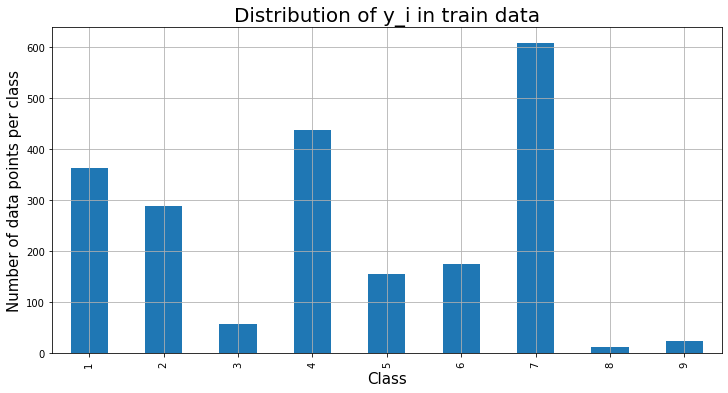

In [33]:
my_colors = 'rgbkymc'
train_class_distribution.plot(kind = 'bar')
plt.xlabel('Class', fontsize = 15)
plt.ylabel('Number of data points per class', fontsize = 15)
plt.title('Distribution of y_i in train data', fontsize = 20)
plt.grid()

#Get current size
fig_size = plt.rcParams["figure.figsize"]
print("Current size:", fig_size)
fig_size[0] = 12
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size

plt.show()

In [34]:
sorted_y_i = np.argsort(-train_class_distribution.values)
for i in sorted_y_i:
    print('Number of data points in class', i+1, ':', train_class_distribution.values[i], '(', np.round(train_class_distribution.values[i]/train_df.shape[0]*100),'% )')

Number of data points in class 7 : 609 ( 29.0 % )
Number of data points in class 4 : 439 ( 21.0 % )
Number of data points in class 1 : 363 ( 17.0 % )
Number of data points in class 2 : 289 ( 14.0 % )
Number of data points in class 6 : 176 ( 8.0 % )
Number of data points in class 5 : 155 ( 7.0 % )
Number of data points in class 3 : 57 ( 3.0 % )
Number of data points in class 9 : 24 ( 1.0 % )
Number of data points in class 8 : 12 ( 1.0 % )


In [35]:
test_class_distribution

1    114
2     91
3     18
4    137
5     48
6     55
7    191
8      4
9      7
Name: Class, dtype: int64

Current size: [12.0, 6.0]


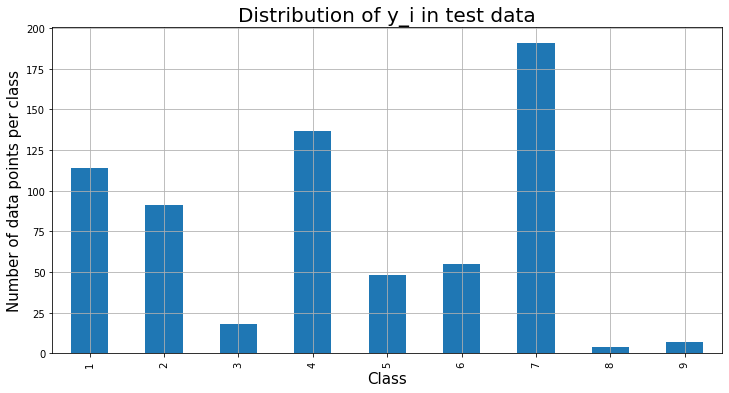

In [36]:
my_colors = 'rgbkymc'
test_class_distribution.plot(kind = 'bar')
plt.xlabel('Class', fontsize = 15)
plt.ylabel('Number of data points per class', fontsize = 15)
plt.title('Distribution of y_i in test data', fontsize = 20)
plt.grid()

#Get current size
fig_size = plt.rcParams["figure.figsize"]
print("Current size:", fig_size)
fig_size[0] = 12
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size

plt.show()

In [37]:
sorted_y_i = np.argsort(-test_class_distribution.values)
for i in sorted_y_i:
    print('Number of data points in class', i+1, ':', test_class_distribution.values[i], '(', np.round(test_class_distribution.values[i]/test_df.shape[0]*100),'% )')

Number of data points in class 7 : 191 ( 29.0 % )
Number of data points in class 4 : 137 ( 21.0 % )
Number of data points in class 1 : 114 ( 17.0 % )
Number of data points in class 2 : 91 ( 14.0 % )
Number of data points in class 6 : 55 ( 8.0 % )
Number of data points in class 5 : 48 ( 7.0 % )
Number of data points in class 3 : 18 ( 3.0 % )
Number of data points in class 9 : 7 ( 1.0 % )
Number of data points in class 8 : 4 ( 1.0 % )


In [38]:
cv_class_distribution

1     91
2     72
3     14
4    110
5     39
6     44
7    153
8      3
9      6
Name: Class, dtype: int64

Current size: [12.0, 6.0]


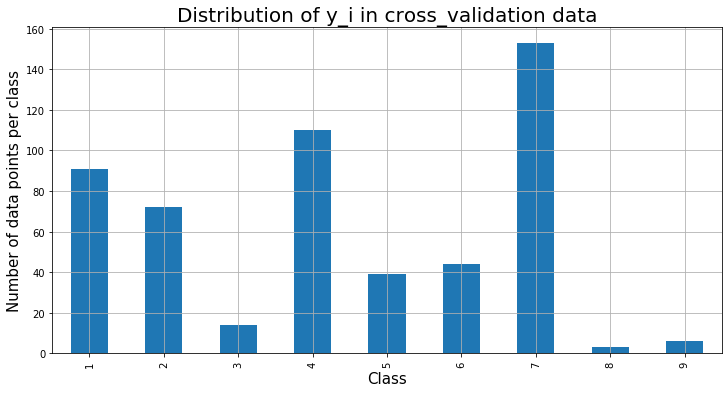

In [39]:
my_colors = 'rgbkymc'
cv_class_distribution.plot(kind = 'bar')
plt.xlabel('Class', fontsize = 15)
plt.ylabel('Number of data points per class', fontsize = 15)
plt.title('Distribution of y_i in cross_validation data', fontsize = 20)
plt.grid()

#Get current size
fig_size = plt.rcParams["figure.figsize"]
print("Current size:", fig_size)
fig_size[0] = 12
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size

plt.show()

In [40]:
sorted_y_i = np.argsort(-cv_class_distribution.values)
for i in sorted_y_i:
    print('Number of data points in class', i+1, ':', cv_class_distribution.values[i], '(', np.round(cv_class_distribution.values[i]/cv_df.shape[0]*100),'% )')

Number of data points in class 7 : 153 ( 29.0 % )
Number of data points in class 4 : 110 ( 21.0 % )
Number of data points in class 1 : 91 ( 17.0 % )
Number of data points in class 2 : 72 ( 14.0 % )
Number of data points in class 6 : 44 ( 8.0 % )
Number of data points in class 5 : 39 ( 7.0 % )
Number of data points in class 3 : 14 ( 3.0 % )
Number of data points in class 9 : 6 ( 1.0 % )
Number of data points in class 8 : 3 ( 1.0 % )


### Buidling a Random Model

We need to generate 9 random numbers as we have 9 classes such that their sum is equal to 1 as the prob. sum would be 1.

In [41]:
test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

In [42]:
#cv_set error
# creating an o/p array that has the same size as cv data

cv_predicted_y = np.zeros((cv_data_len,9))  #as there are 9 classes
                                            #and filling all the values as zeros in the cross validation dataset
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)        #now randomly putting values in the slots
                                            #but the sum may not be one
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])     #so dividing by the sum of all those parts
    
print('Log Loss on CV data using a Random model: {}'.format(log_loss(y_cv, cv_predicted_y, eps = 1e-15)))
                                                                    #actual o/p     |
                                                                                                   
                                                                           #predicted o/p                     

Log Loss on CV data using a Random model: 2.468543991938514


In [43]:
# Test-Set error.
#we create a output array that has exactly same as the test data

test_predicted_y = np.zeros((test_data_len,9))

for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)

    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])

print("Log loss on Test Data using a Random model: {}".format(log_loss(y_test, test_predicted_y, eps=1e-10)))

Log loss on Test Data using a Random model: 2.5257897339516684


The model must have log_loss less than this

In [44]:
# let's get the index of the max prob

predicted_y = np.argmax(test_predicted_y, axis = 1)

In [45]:
predicted_y

array([7, 4, 7, 6, 4, 3, 8, 0, 5, 7, 0, 0, 3, 4, 5, 3, 8, 3, 2, 6, 7, 2,
       5, 7, 7, 5, 2, 6, 0, 2, 0, 5, 2, 2, 5, 4, 6, 0, 7, 6, 8, 0, 7, 2,
       5, 1, 7, 7, 8, 8, 8, 7, 1, 5, 1, 3, 2, 5, 2, 0, 8, 6, 7, 1, 6, 7,
       0, 3, 8, 2, 5, 5, 5, 6, 3, 1, 2, 7, 6, 7, 6, 8, 0, 5, 1, 4, 7, 7,
       6, 6, 3, 5, 8, 7, 4, 3, 7, 4, 6, 8, 5, 7, 5, 7, 4, 8, 1, 3, 2, 4,
       8, 8, 7, 1, 3, 5, 6, 3, 3, 5, 4, 2, 5, 1, 3, 3, 4, 2, 6, 1, 8, 7,
       7, 6, 7, 2, 6, 2, 3, 2, 2, 4, 0, 4, 6, 7, 6, 4, 0, 6, 8, 3, 2, 8,
       5, 6, 3, 3, 4, 0, 0, 8, 8, 8, 2, 5, 3, 2, 7, 2, 5, 1, 0, 4, 1, 7,
       6, 4, 0, 1, 5, 3, 6, 5, 2, 7, 6, 5, 4, 8, 4, 2, 5, 2, 1, 6, 7, 8,
       6, 4, 5, 8, 1, 5, 5, 7, 0, 6, 4, 7, 0, 2, 2, 2, 2, 8, 3, 7, 3, 2,
       5, 8, 4, 0, 4, 5, 5, 6, 3, 0, 6, 8, 3, 2, 4, 7, 8, 6, 0, 5, 1, 5,
       4, 2, 3, 5, 1, 7, 3, 4, 0, 2, 1, 2, 3, 8, 1, 3, 0, 6, 0, 6, 7, 5,
       0, 6, 8, 1, 5, 7, 5, 0, 5, 1, 1, 7, 2, 1, 4, 4, 1, 2, 7, 0, 7, 7,
       6, 8, 7, 0, 7, 4, 8, 3, 3, 0, 5, 6, 4, 1, 8,

In [46]:
# since it has values from 0 - 8, let's add 1 to each

predicted_y += 1

In [47]:
predicted_y

array([8, 5, 8, 7, 5, 4, 9, 1, 6, 8, 1, 1, 4, 5, 6, 4, 9, 4, 3, 7, 8, 3,
       6, 8, 8, 6, 3, 7, 1, 3, 1, 6, 3, 3, 6, 5, 7, 1, 8, 7, 9, 1, 8, 3,
       6, 2, 8, 8, 9, 9, 9, 8, 2, 6, 2, 4, 3, 6, 3, 1, 9, 7, 8, 2, 7, 8,
       1, 4, 9, 3, 6, 6, 6, 7, 4, 2, 3, 8, 7, 8, 7, 9, 1, 6, 2, 5, 8, 8,
       7, 7, 4, 6, 9, 8, 5, 4, 8, 5, 7, 9, 6, 8, 6, 8, 5, 9, 2, 4, 3, 5,
       9, 9, 8, 2, 4, 6, 7, 4, 4, 6, 5, 3, 6, 2, 4, 4, 5, 3, 7, 2, 9, 8,
       8, 7, 8, 3, 7, 3, 4, 3, 3, 5, 1, 5, 7, 8, 7, 5, 1, 7, 9, 4, 3, 9,
       6, 7, 4, 4, 5, 1, 1, 9, 9, 9, 3, 6, 4, 3, 8, 3, 6, 2, 1, 5, 2, 8,
       7, 5, 1, 2, 6, 4, 7, 6, 3, 8, 7, 6, 5, 9, 5, 3, 6, 3, 2, 7, 8, 9,
       7, 5, 6, 9, 2, 6, 6, 8, 1, 7, 5, 8, 1, 3, 3, 3, 3, 9, 4, 8, 4, 3,
       6, 9, 5, 1, 5, 6, 6, 7, 4, 1, 7, 9, 4, 3, 5, 8, 9, 7, 1, 6, 2, 6,
       5, 3, 4, 6, 2, 8, 4, 5, 1, 3, 2, 3, 4, 9, 2, 4, 1, 7, 1, 7, 8, 6,
       1, 7, 9, 2, 6, 8, 6, 1, 6, 2, 2, 8, 3, 2, 5, 5, 2, 3, 8, 1, 8, 8,
       7, 9, 8, 1, 8, 5, 9, 4, 4, 1, 6, 7, 5, 2, 9,

## Confusion matrix

In [48]:
C = confusion_matrix(y_test, predicted_y)

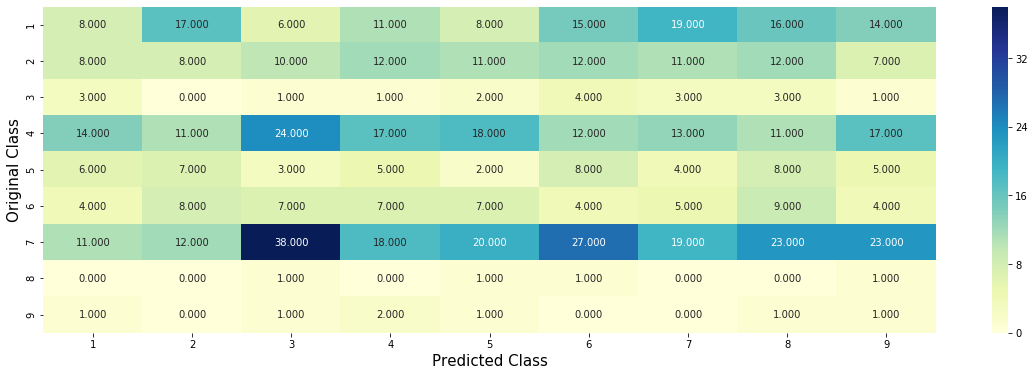

In [49]:
labels = [1,2,3,4,5,6,7,8,9]
plt.figure(figsize = (20,6))
sns.heatmap(C, annot = True, cmap = 'YlGnBu', fmt = '.3f', xticklabels = labels, yticklabels = labels)
plt.xlabel('Predicted Class', fontsize = 15)
plt.ylabel('Original Class', fontsize = 15)
plt.show()

## Precision matrix

In [50]:
B = (C/C.sum(axis = 0))

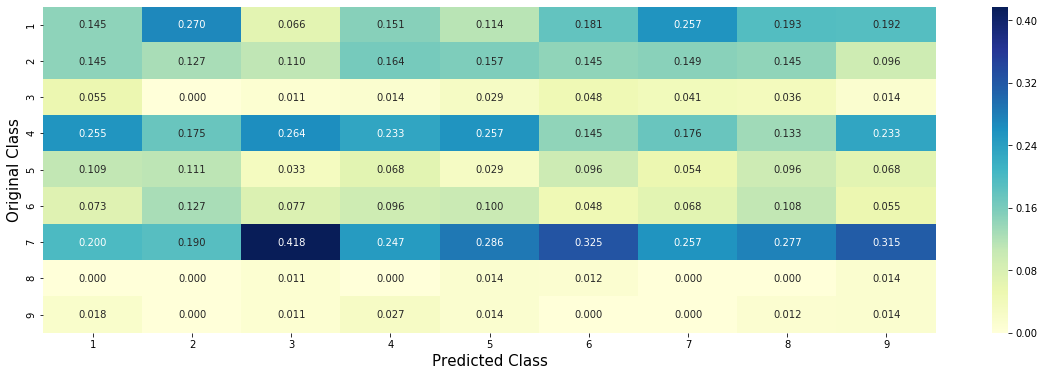

In [51]:
plt.figure(figsize = (20,6))
sns.heatmap(B, annot = True, cmap = 'YlGnBu', fmt = '.3f', xticklabels = labels, yticklabels = labels)
plt.xlabel('Predicted Class', fontsize = 15)
plt.ylabel('Original Class', fontsize = 15)
plt.show()

## Recall matrix

In [52]:
A = (((C.T)/(C.sum(axis = 1))).T)

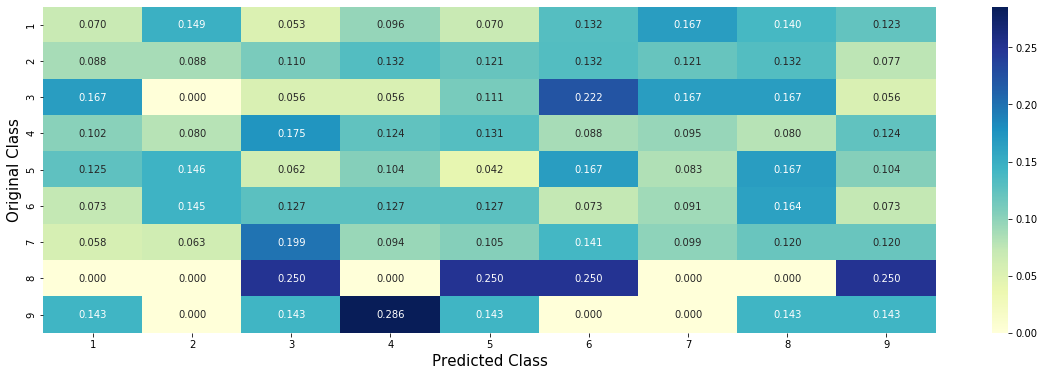

In [53]:
plt.figure(figsize = (20,6))
sns.heatmap(A, annot = True, cmap = 'YlGnBu', fmt = '.3f', xticklabels = labels, yticklabels = labels)
plt.xlabel('Predicted Class', fontsize = 15)
plt.ylabel('Original Class', fontsize= 15)
plt.show()

## Playing with the columns

### First categorical column

In [54]:
# Evaluating Gene column to understand if there is any relation between the class and the genes

unique_genes = train_df['Gene'].value_counts()
print('Number of unique genes: {}'.format(unique_genes.shape[0]))

#printing the 20 most occurred ones
print(unique_genes.head(20))

Number of unique genes: 235
BRCA1     170
TP53       94
EGFR       82
PTEN       78
BRCA2      78
KIT        65
BRAF       60
ERBB2      46
ALK        44
PDGFRA     41
CDKN2A     36
PIK3CA     34
RET        32
FLT3       32
FGFR2      29
MAP2K1     29
KRAS       29
MTOR       28
TSC2       27
FGFR3      25
Name: Gene, dtype: int64


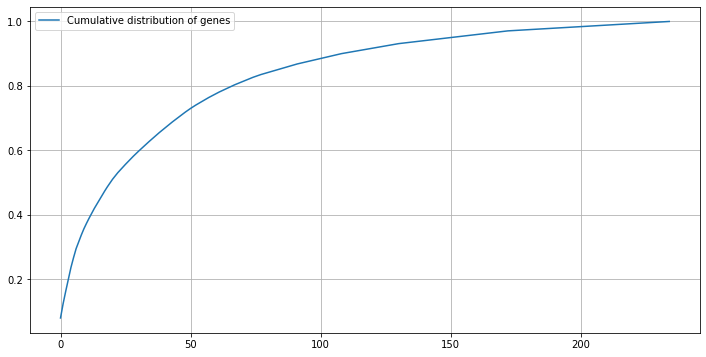

<Figure size 1152x576 with 0 Axes>

In [55]:
#To have a better understanding we make a plot

s = sum(unique_genes.values)
h = unique_genes.values/s
c = np.cumsum(h)

plt.plot(c, label = 'Cumulative distribution of genes')
plt.grid()
plt.legend()
plt.figure(figsize = (16,8))
plt.show()

Now, we need to convert these categorical variable to appropirate format which the machine learning algorithm will be able to take as an input. The techniques would be:

***One-hot encoding***

***Response Encoding*** (Mean imputation)

In [56]:
# one-hot encoding of Gene feature.
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

In [57]:
train_gene_feature_onehotCoding.shape

(2124, 234)

In [58]:
#column names after one-hot encoding for Gene column
gene_vectorizer.get_feature_names()

['abl1',
 'acvr1',
 'ago2',
 'akt1',
 'akt2',
 'akt3',
 'alk',
 'apc',
 'ar',
 'araf',
 'arid1a',
 'arid1b',
 'arid2',
 'asxl1',
 'asxl2',
 'atm',
 'atr',
 'atrx',
 'aurka',
 'axl',
 'b2m',
 'bap1',
 'bard1',
 'bcl10',
 'bcor',
 'braf',
 'brca1',
 'brca2',
 'brd4',
 'brip1',
 'btk',
 'card11',
 'carm1',
 'casp8',
 'cbl',
 'ccnd1',
 'ccnd2',
 'ccnd3',
 'ccne1',
 'cdh1',
 'cdk12',
 'cdk4',
 'cdk6',
 'cdk8',
 'cdkn1a',
 'cdkn1b',
 'cdkn2a',
 'cdkn2b',
 'cdkn2c',
 'chek2',
 'cic',
 'crebbp',
 'ctcf',
 'ctla4',
 'ctnnb1',
 'ddr2',
 'dicer1',
 'dnmt3a',
 'dnmt3b',
 'dusp4',
 'egfr',
 'eif1ax',
 'elf3',
 'ep300',
 'epas1',
 'epcam',
 'erbb2',
 'erbb3',
 'erbb4',
 'ercc2',
 'ercc4',
 'erg',
 'errfi1',
 'esr1',
 'etv1',
 'etv6',
 'ewsr1',
 'ezh2',
 'fanca',
 'fancc',
 'fat1',
 'fbxw7',
 'fgf19',
 'fgf3',
 'fgfr1',
 'fgfr2',
 'fgfr3',
 'fgfr4',
 'flt1',
 'flt3',
 'foxa1',
 'foxl2',
 'foxo1',
 'foxp1',
 'gata3',
 'gli1',
 'gnas',
 'h3f3a',
 'hist1h1c',
 'hla',
 'hnf1a',
 'hras',
 'idh1',
 'idh2',

In [59]:
# code for response coding with Laplace smoothing.


# alpha : used for laplace smoothing
# feature: ['gene', 'variation']
# df: ['train_df', 'test_df', 'cv_df']
# algorithm
# ----------
# Consider all unique values and the number of occurances of given feature in train data dataframe
# build a vector (1*9) , the first element = (number of times it occured in class1 + 10*alpha / number of time it occurred in total data+90*alpha)
# gv_dict is like a look up table, for every gene it store a (1*9) representation of it
# for a value of feature in df:
# if it is in train data:
# we add the vector that was stored in 'gv_dict' look up table to 'gv_fea'
# if it is not there is train:
# we add [1/9, 1/9, 1/9, 1/9,1/9, 1/9, 1/9, 1/9, 1/9] to 'gv_fea'
# return 'gv_fea'
# ----------------------


# get_gv_fea_dict: Get Gene varaition Feature Dict
def get_gv_fea_dict(alpha, feature, df):
    # value_count: it contains a dict like
    # print(train_df['Gene'].value_counts())
    # output:
    #        {BRCA1      174
    #         TP53       106
    #         EGFR        86
    #         BRCA2       75
    #         PTEN        69
    #         KIT         61
    #         BRAF        60
    #         ERBB2       47
    #         PDGFRA      46
    #         ...}
    # print(train_df['Variation'].value_counts())
    # output:
    # {
    # Truncating_Mutations                     63
    # Deletion                                 43
    # Amplification                            43
    # Fusions                                  22
    # Overexpression                            3
    # E17K                                      3
    # Q61L                                      3
    # S222D                                     2
    # P130S                                     2
    # ...
    # }
    value_count = train_df[feature].value_counts()
    
    # gv_dict : Gene Variation Dict, which contains the probability array for each gene/variation
    gv_dict = dict()
    
    # denominator will contain the number of time that particular feature occured in whole data
    for i, denominator in value_count.items():
        # vec will contain (p(yi==1/Gi) probability of gene/variation belongs to perticular class
        # vec is 9 diamensional vector
        vec = []
        for k in range(1,10):
            # print(train_df.loc[(train_df['Class']==1) & (train_df['Gene']=='BRCA1')])
            #         ID   Gene             Variation  Class  
            # 2470  2470  BRCA1                S1715C      1   
            # 2486  2486  BRCA1                S1841R      1   
            # 2614  2614  BRCA1                   M1R      1   
            # 2432  2432  BRCA1                L1657P      1   
            # 2567  2567  BRCA1                T1685A      1   
            # 2583  2583  BRCA1                E1660G      1   
            # 2634  2634  BRCA1                W1718L      1   
            # cls_cnt.shape[0] will return the number of rows

            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
            
            # cls_cnt.shape[0](numerator) will contain the number of time that particular feature occured in whole data
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))

        # we are adding the gene/variation to the dict as key and vec as value
        gv_dict[i]=vec
    return gv_dict

# Get Gene variation feature
def get_gv_feature(alpha, feature, df):
    # print(gv_dict)
    #     {'BRCA1': [0.20075757575757575, 0.03787878787878788, 0.068181818181818177, 0.13636363636363635, 0.25, 0.19318181818181818, 0.03787878787878788, 0.03787878787878788, 0.03787878787878788], 
    #      'TP53': [0.32142857142857145, 0.061224489795918366, 0.061224489795918366, 0.27040816326530615, 0.061224489795918366, 0.066326530612244902, 0.051020408163265307, 0.051020408163265307, 0.056122448979591837], 
    #      'EGFR': [0.056818181818181816, 0.21590909090909091, 0.0625, 0.068181818181818177, 0.068181818181818177, 0.0625, 0.34659090909090912, 0.0625, 0.056818181818181816], 
    #      'BRCA2': [0.13333333333333333, 0.060606060606060608, 0.060606060606060608, 0.078787878787878782, 0.1393939393939394, 0.34545454545454546, 0.060606060606060608, 0.060606060606060608, 0.060606060606060608], 
    #      'PTEN': [0.069182389937106917, 0.062893081761006289, 0.069182389937106917, 0.46540880503144655, 0.075471698113207544, 0.062893081761006289, 0.069182389937106917, 0.062893081761006289, 0.062893081761006289], 
    #      'KIT': [0.066225165562913912, 0.25165562913907286, 0.072847682119205295, 0.072847682119205295, 0.066225165562913912, 0.066225165562913912, 0.27152317880794702, 0.066225165562913912, 0.066225165562913912], 
    #      'BRAF': [0.066666666666666666, 0.17999999999999999, 0.073333333333333334, 0.073333333333333334, 0.093333333333333338, 0.080000000000000002, 0.29999999999999999, 0.066666666666666666, 0.066666666666666666],
    #      ...
    #     }
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    # value_count is similar in get_gv_fea_dict
    value_count = train_df[feature].value_counts()
    
     # gv_fea: Gene_variation feature, it will contain the feature for each feature value in the data
    gv_fea = []
    # for every feature values in the given data frame we will check if it is there in the train data then we will add the feature to gv_fea
    # if not we will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to gv_fea
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
#             gv_fea.append([-1,-1,-1,-1,-1,-1,-1,-1,-1])
    return gv_fea

In [60]:
#response-coding of the Gene feature

# alpha is used for laplace smoothing
alpha = 1

# train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", train_df))

# test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", test_df))

# cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", cv_df))

In [61]:
train_gene_feature_responseCoding.shape

(2124, 9)

Now, question is how good is Gene column feature to predict 9 classes. One idea could be to build model having only gene column with one hot encoder with simple model like Logistic regression. If log loss with only one column Gene comes out to be better than random model, than this feature is important.

##### Using SGD(Stochastic Gradient Descent) Classifier

In [62]:
# We need a hyperparemeter for SGD classifier.
alpha = [10 ** x for x in range(-6, 2)]

In [63]:
# We will also be using Calibrated Classifier to get the result into probablity format to be used for log loss
cv_log_error_array=[]

for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    
    clf.fit(train_gene_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

For values of alpha =  1e-06 The log loss is: 1.3224871270694023
For values of alpha =  1e-05 The log loss is: 1.187845646440806
For values of alpha =  0.0001 The log loss is: 1.1645076201726379
For values of alpha =  0.001 The log loss is: 1.1899523019802891
For values of alpha =  0.01 The log loss is: 1.280839706170361
For values of alpha =  0.1 The log loss is: 1.3962489496936556
For values of alpha =  1 The log loss is: 1.4404326416166138
For values of alpha =  10 The log loss is: 1.4460373788909173


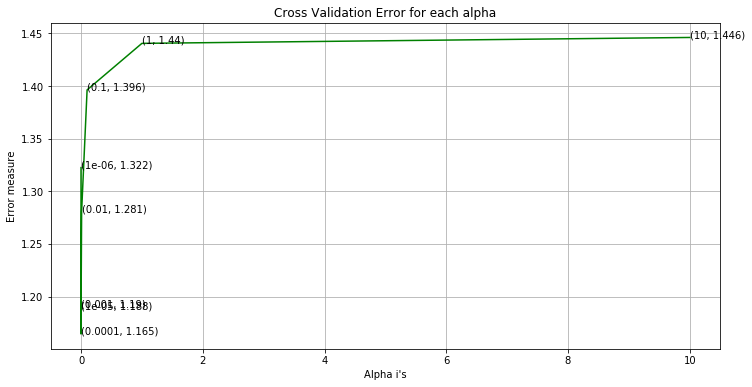

In [64]:
# Lets plot the same to check the best Alpha value
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [65]:
# Lets use best alpha value as we can see from above graph and compute log loss
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.0001 The train log loss is: 0.9919331871811868
For values of best alpha =  0.0001 The cross validation log loss is: 1.1645076201726379
For values of best alpha =  0.0001 The test log loss is: 1.2126674666271056



Now lets check how many values are overlapping between train, test or between CV and train

In [66]:
test_coverage=test_df[test_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]
cv_coverage=cv_df[cv_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]

In [67]:
print('1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

1. In test data 646 out of 665 : 97.14285714285714
2. In cross validation data 518 out of  532 : 97.36842105263158


### Second Categorical Column analysis

In [68]:
# Evaluating Variation column

# Variation is also a categorical variable so we have to deal in same way like we have done for Gene column.
# We will again get the one hot encoder and response enoding variable for variation column.


unique_variations = train_df['Variation'].value_counts()

print('Number of Unique Variations :', unique_variations.shape[0])

# the top 20 variations that occured most
print(unique_variations.head(20))

Number of Unique Variations : 1930
Truncating_Mutations    60
Deletion                46
Amplification           46
Fusions                 22
G12V                     3
E17K                     3
F28L                     2
C618R                    2
R170W                    2
G67R                     2
TMPRSS2-ETV1_Fusion      2
F384L                    2
M1R                      2
S308A                    2
Q61L                     2
T286A                    2
Q61K                     2
R841K                    2
Y64A                     2
G13D                     2
Name: Variation, dtype: int64


[0.02824859 0.04990584 0.07156309 ... 0.99905838 0.99952919 1.        ]


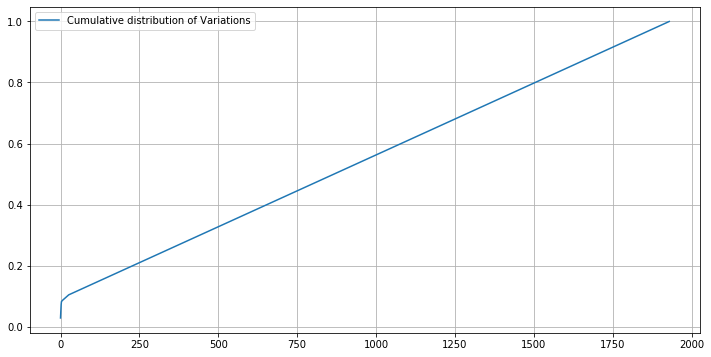

In [69]:
# cumulative distribution of unique variation values

s = sum(unique_variations.values);
h = unique_variations.values/s;
c = np.cumsum(h)
print(c)
plt.plot(c,label='Cumulative distribution of Variations')
plt.grid()
plt.legend()
plt.show()

In [70]:
# one-hot encoding of variation feature.
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

In [71]:
train_variation_feature_onehotCoding.shape

(2124, 1961)

In [72]:
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", train_df))
# test gene feature
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", test_df))
# cross validation gene feature
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", cv_df))

In [73]:
train_variation_feature_responseCoding.shape

(2124, 9)

##### Using SGD classifier

In [74]:
# We need a hyperparemeter for SGD classifier.
alpha = [10 ** x for x in range(-5, 1)]

In [75]:
# We will also be using Calibrated Classifier to get the result into probablity format t be used for log loss
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_variation_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
    
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

For values of alpha =  1e-05 The log loss is: 1.709036113109659
For values of alpha =  0.0001 The log loss is: 1.70550345467966
For values of alpha =  0.001 The log loss is: 1.7067381394347063
For values of alpha =  0.01 The log loss is: 1.7135232424904174
For values of alpha =  0.1 The log loss is: 1.7277367606525305
For values of alpha =  1 The log loss is: 1.7304783860658584


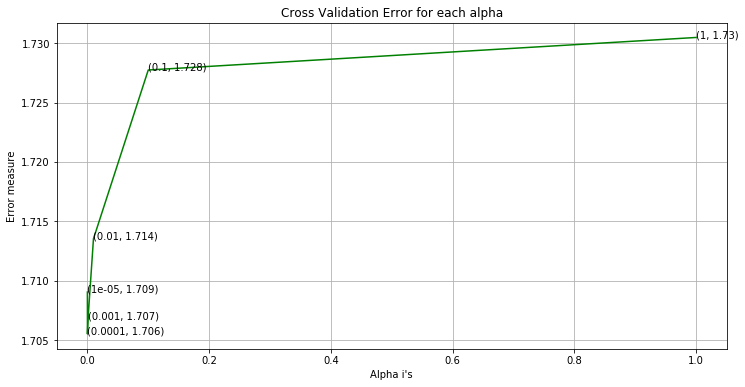

In [76]:
# Lets plot the same to check the best Alpha value
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


In [77]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.0001 The train log loss is: 0.7620490333751505
For values of best alpha =  0.0001 The cross validation log loss is: 1.70550345467966
For values of best alpha =  0.0001 The test log loss is: 1.6978207232522542


In [78]:
test_coverage=test_df[test_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
cv_coverage=cv_df[cv_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]

In [79]:
print('1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

1. In test data 72 out of 665 : 10.827067669172932
2. In cross validation data 56 out of  532 : 10.526315789473683


### Third Categorical Column Analysis

In [80]:
# Evaluating text column

# cls_text is a data frame
# for every row in data fram consider the 'TEXT'
# split the words by space
# make a dict with those words
# increment its count whenever we see that word

def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [81]:
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

In [82]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 53214


In [83]:
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(train_df)


confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [84]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df)

In [85]:
# we convert each row values such that they sum to 1  
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [86]:
# don't forget to normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [87]:
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [88]:
# Number of words for a given frequency.
print(Counter(sorted_text_occur))

Counter({3: 5393, 4: 3558, 6: 2812, 5: 2759, 7: 2248, 9: 1834, 8: 1804, 10: 1571, 12: 1195, 11: 1114, 14: 1081, 15: 888, 13: 881, 17: 854, 16: 696, 18: 676, 20: 640, 19: 526, 24: 511, 21: 492, 22: 468, 28: 436, 30: 384, 42: 370, 27: 360, 26: 352, 23: 349, 25: 337, 48: 303, 32: 289, 31: 289, 29: 285, 33: 273, 36: 263, 34: 263, 39: 240, 35: 231, 40: 217, 37: 217, 44: 190, 41: 181, 38: 177, 52: 167, 50: 166, 56: 163, 43: 162, 51: 156, 45: 155, 49: 144, 46: 142, 55: 134, 53: 134, 47: 133, 62: 128, 57: 128, 61: 127, 59: 123, 54: 123, 60: 121, 58: 121, 64: 115, 72: 112, 66: 108, 68: 105, 63: 105, 70: 104, 78: 100, 65: 100, 69: 98, 67: 98, 84: 85, 82: 82, 71: 82, 76: 81, 75: 81, 80: 80, 74: 79, 79: 76, 77: 76, 88: 75, 83: 75, 90: 71, 85: 70, 81: 70, 73: 70, 120: 68, 86: 67, 96: 66, 87: 65, 98: 64, 91: 64, 89: 61, 102: 59, 115: 58, 110: 58, 100: 57, 94: 57, 92: 56, 104: 55, 97: 55, 109: 52, 99: 51, 93: 51, 112: 50, 106: 50, 130: 49, 103: 48, 101: 48, 95: 47, 114: 46, 111: 46, 129: 44, 119: 44,

Building the model with only text column

In [89]:
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

For values of alpha =  1e-05 The log loss is: 1.2748409387364141
For values of alpha =  0.0001 The log loss is: 1.0896064867254545
For values of alpha =  0.001 The log loss is: 1.0410902968652762
For values of alpha =  0.01 The log loss is: 1.1244720005121105
For values of alpha =  0.1 The log loss is: 1.4390326687167416
For values of alpha =  1 The log loss is: 1.644144075441879


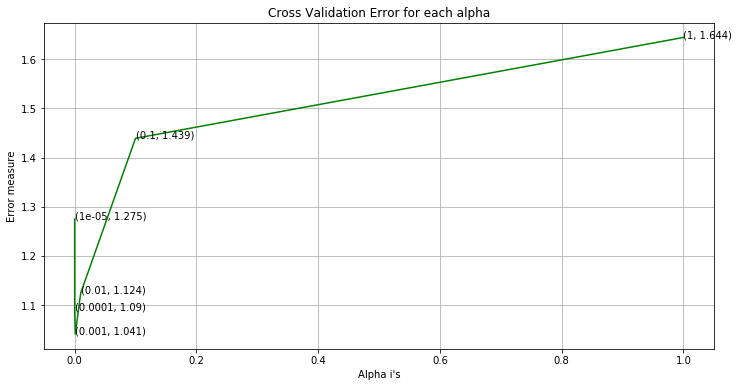

In [90]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [91]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.001 The train log loss is: 0.69289048445732
For values of best alpha =  0.001 The cross validation log loss is: 1.0410902968652762
For values of best alpha =  0.001 The test log loss is: 1.2231113527906654


In [92]:
# checking overlapping of text data

def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

In [93]:
len1,len2 = get_intersec_text(test_df)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")
len1,len2 = get_intersec_text(cv_df)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

96.651 % of word of test data appeared in train data
98.101 % of word of Cross Validation appeared in train data


Hence all the data columns are important for consideration

## Data preparation for ML models

##### Creating a few functions for later usage

In [94]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [95]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0)) 
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()


def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [96]:
# this function will be used just for naive bayes
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

### Combining all the features together

In [97]:
# merging gene, variance and text features

# building train, test and cross validation data sets
# a = [[1, 2], 
#      [3, 4]]
# b = [[4, 5], 
#      [6, 7]]
# hstack(a, b) = [[1, 2, 4, 5],
#                [ 3, 4, 6, 7]]

train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))

train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))

In [98]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 55409)
(number of data points * number of features) in test data =  (665, 55409)
(number of data points * number of features) in cross validation data = (532, 55409)


In [99]:
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)

 Response encoding features :
(number of data points * number of features) in train data =  (2124, 27)
(number of data points * number of features) in test data =  (665, 27)
(number of data points * number of features) in cross validation data = (532, 27)


## Building Machine Learning Model

Lets start the first model which is most suitable when we have lot of text column data. So, we will start with Naive Bayes.

### Naive Bayes

In [100]:
# http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs))

for alpha = 1e-05
Log Loss : 1.2066627792100093
for alpha = 0.0001
Log Loss : 1.2067058603097112
for alpha = 0.001
Log Loss : 1.1974753480839173
for alpha = 0.1
Log Loss : 1.189317260044195
for alpha = 1
Log Loss : 1.2164344706050296
for alpha = 10
Log Loss : 1.3187396845961044
for alpha = 100
Log Loss : 1.2620518102210296
for alpha = 1000
Log Loss : 1.2037871527076889


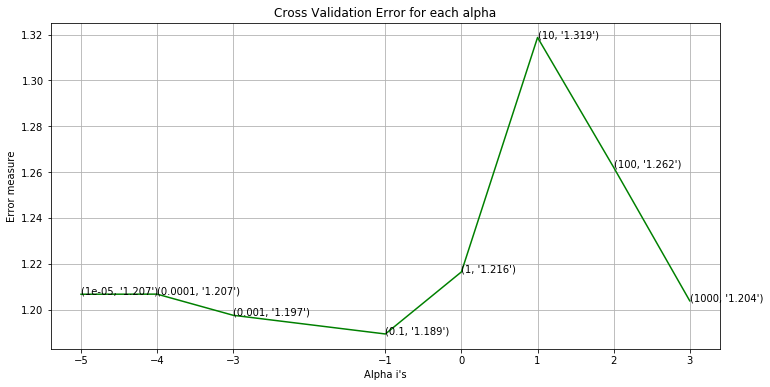

In [101]:
fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [102]:
best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.1 The train log loss is: 0.9018131327551189
For values of best alpha =  0.1 The cross validation log loss is: 1.189317260044195
For values of best alpha =  0.1 The test log loss is: 1.3187406305054552


Log Loss : 1.189317260044195
Number of missclassified point : 0.34962406015037595
-------------------- Confusion matrix --------------------


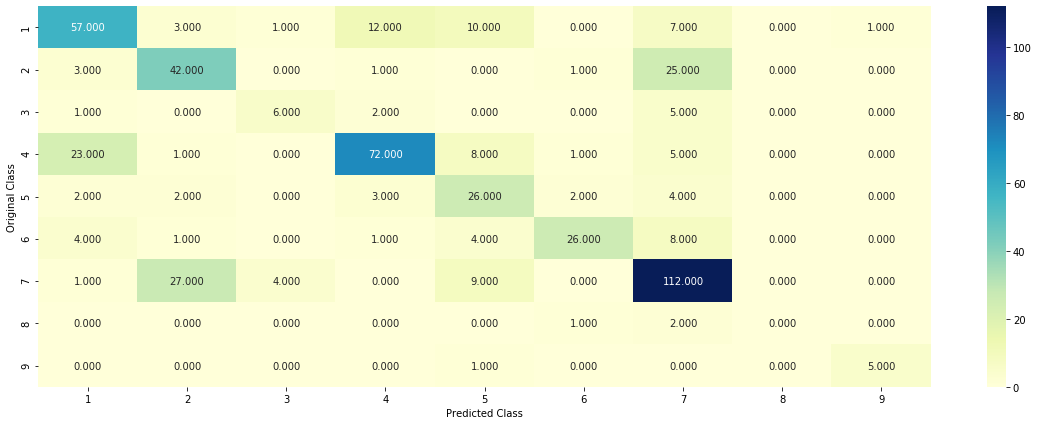

-------------------- Precision matrix (Columm Sum=1) --------------------


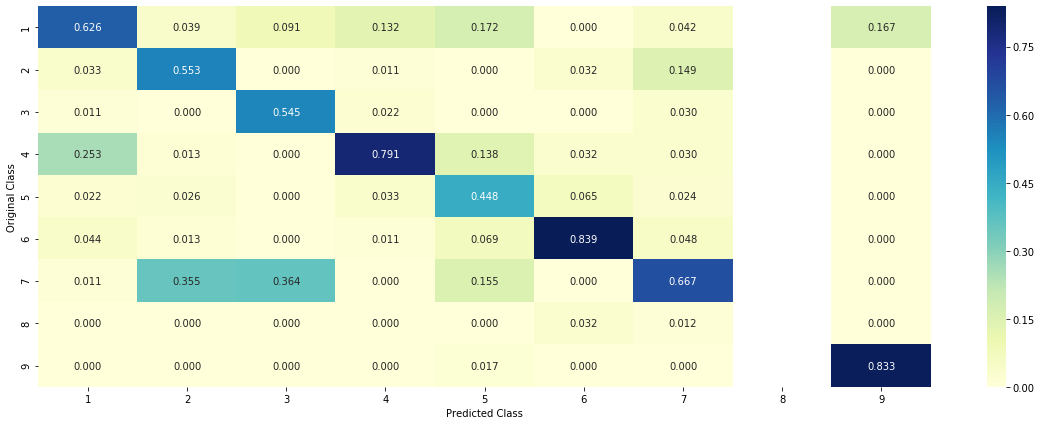

-------------------- Recall matrix (Row sum=1) --------------------


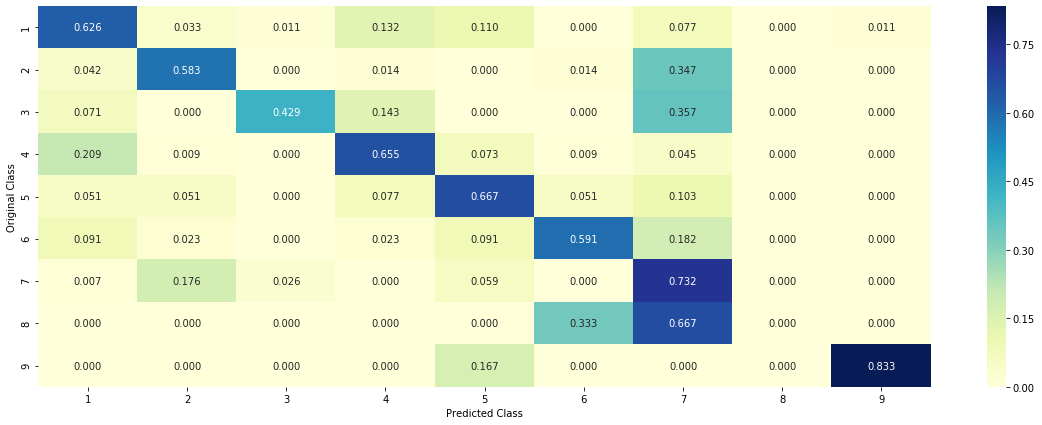

In [103]:
# Testing our Naive Bayes model with best found value of alpha on testing data

clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

### Interpretability of our model

In [104]:
test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.099  0.3292 0.012  0.1241 0.0389 0.0357 0.3525 0.0048 0.0039]]
Actual Class : 7
--------------------------------------------------
17 Text feature [kinase] present in test data point [True]
21 Text feature [well] present in test data point [True]
22 Text feature [previously] present in test data point [True]
23 Text feature [cell] present in test data point [True]
24 Text feature [cells] present in test data point [True]
25 Text feature [activation] present in test data point [True]
26 Text feature [recently] present in test data point [True]
27 Text feature [higher] present in test data point [True]
28 Text feature [showed] present in test data point [True]
29 Text feature [potential] present in test data point [True]
34 Text feature [expressing] present in test data point [True]
36 Text feature [10] present in test data point [True]
37 Text feature [independent] present in test data point [True]
38 Text feature [shown] present in

In [105]:
## looking at one more point

test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.08   0.0708 0.0096 0.6438 0.0317 0.0295 0.1276 0.0038 0.0032]]
Actual Class : 4
--------------------------------------------------
11 Text feature [function] present in test data point [True]
12 Text feature [protein] present in test data point [True]
14 Text feature [proteins] present in test data point [True]
15 Text feature [functional] present in test data point [True]
17 Text feature [activity] present in test data point [True]
28 Text feature [results] present in test data point [True]
29 Text feature [phosphatase] present in test data point [True]
30 Text feature [loss] present in test data point [True]
32 Text feature [whereas] present in test data point [True]
33 Text feature [determined] present in test data point [True]
34 Text feature [whether] present in test data point [True]
37 Text feature [type] present in test data point [True]
39 Text feature [lack] present in test data point [True]
42 Text feature [affect] prese

### KNN Classification

In [106]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs))

for alpha = 5
Log Loss : 0.9682069428440477
for alpha = 11
Log Loss : 0.9583655363469714
for alpha = 15
Log Loss : 0.9648901881500074
for alpha = 21
Log Loss : 0.9807553025483351
for alpha = 31
Log Loss : 0.9935246591535598
for alpha = 41
Log Loss : 1.0168005526089363
for alpha = 51
Log Loss : 1.0224636993934721
for alpha = 99
Log Loss : 1.0586687805124169


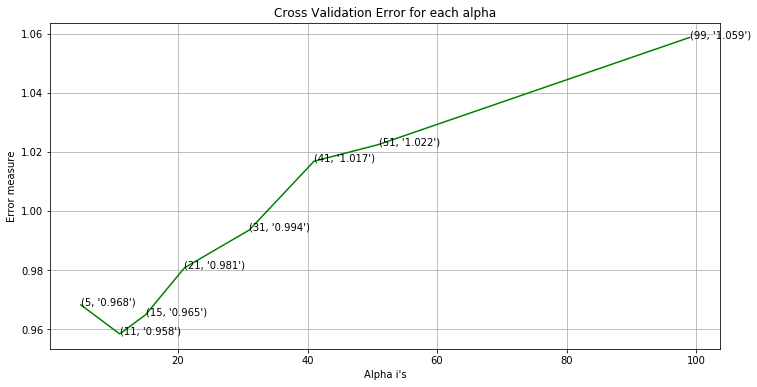

In [107]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [108]:
best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  11 The train log loss is: 0.6552533571837716
For values of best alpha =  11 The cross validation log loss is: 0.9583655363469714
For values of best alpha =  11 The test log loss is: 1.1035577181941523


Log loss : 0.9583655363469714
Number of mis-classified points : 0.35714285714285715
-------------------- Confusion matrix --------------------


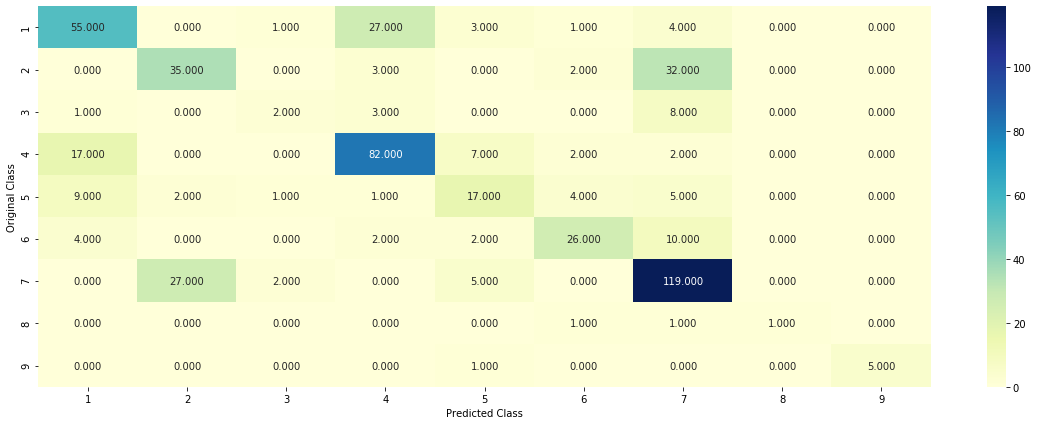

-------------------- Precision matrix (Columm Sum=1) --------------------


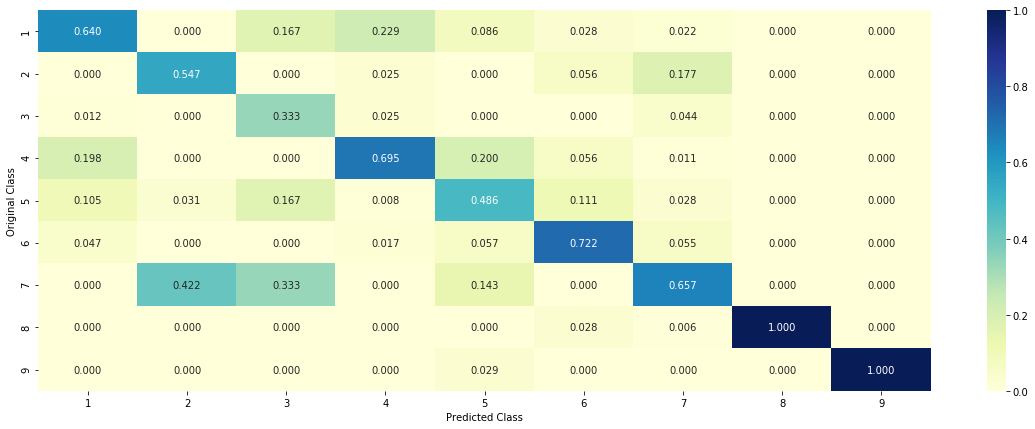

-------------------- Recall matrix (Row sum=1) --------------------


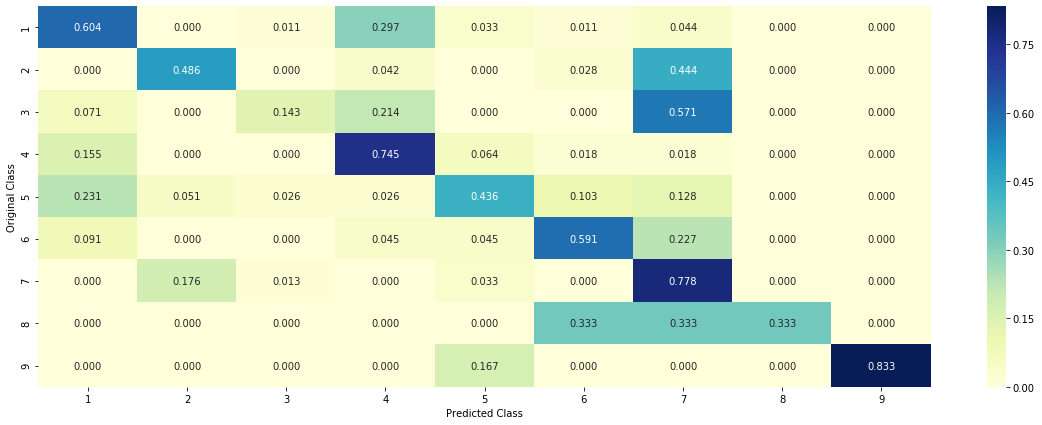

In [109]:
# testing dataset with best alpha value

clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf)

In [110]:
# Lets look at few test points
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 1
predicted_cls = sig_clf.predict(test_x_responseCoding[0].reshape(1,-1))
print("Actual Class :", predicted_cls[0])
print("Predicted Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Actual Class : 7
Predicted Class : 7
The  11  nearest neighbours of the test points belongs to classes [7 2 7 2 2 7 2 7 7 7 7]
Fequency of nearest points : Counter({7: 7, 2: 4})


In [111]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 100

predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Actual Class :", predicted_cls[0])
print("Predicted Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("the k value for knn is",alpha[best_alpha],"and the nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Actual Class : 4
Predicted Class : 4
the k value for knn is 11 and the nearest neighbours of the test points belongs to classes [4 4 4 4 4 4 3 4 4 2 4]
Fequency of nearest points : Counter({4: 9, 3: 1, 2: 1})


## Logistic Regression

##### Balancing all cases

In [112]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs))

for alpha = 1e-06
Log Loss : 1.2519031259399647
for alpha = 1e-05
Log Loss : 1.2046109268994853
for alpha = 0.0001
Log Loss : 1.0035580773540382
for alpha = 0.001
Log Loss : 0.9689317428706039
for alpha = 0.01
Log Loss : 1.024393321371164
for alpha = 0.1
Log Loss : 1.4080018895648305
for alpha = 1
Log Loss : 1.6494948870560224
for alpha = 10
Log Loss : 1.6771007195884402
for alpha = 100
Log Loss : 1.6800047797962647


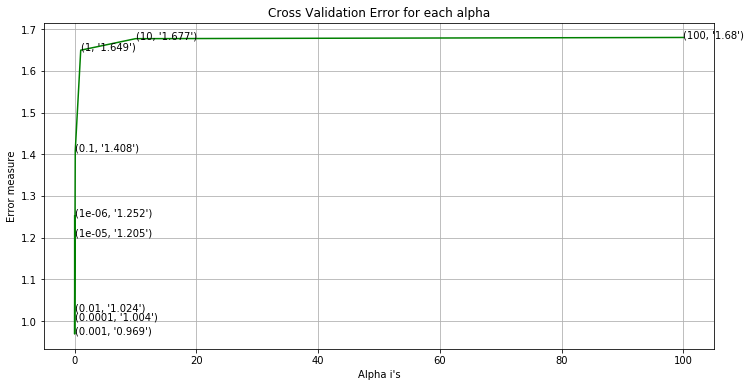

In [113]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [114]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.001 The train log loss is: 0.5590252892095888
For values of best alpha =  0.001 The cross validation log loss is: 0.9689317428706039
For values of best alpha =  0.001 The test log loss is: 1.1578042449515147


Log loss : 0.9689317428706039
Number of mis-classified points : 0.3007518796992481
-------------------- Confusion matrix --------------------


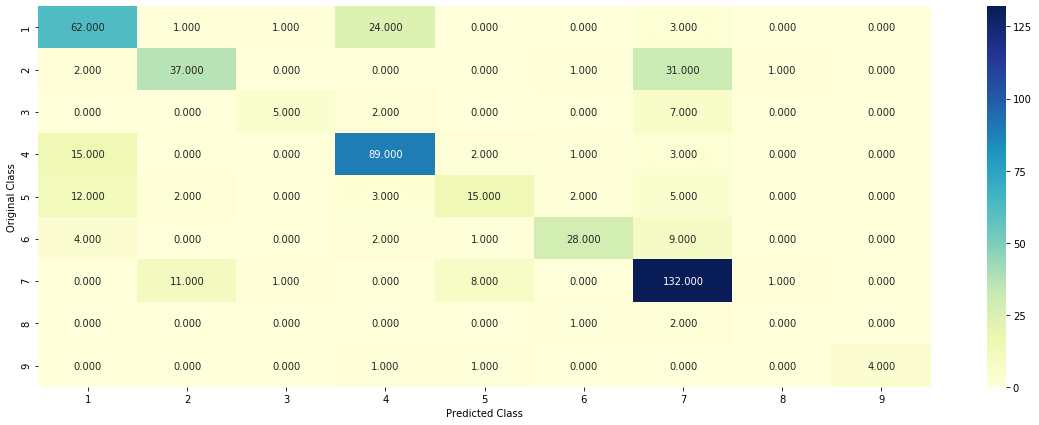

-------------------- Precision matrix (Columm Sum=1) --------------------


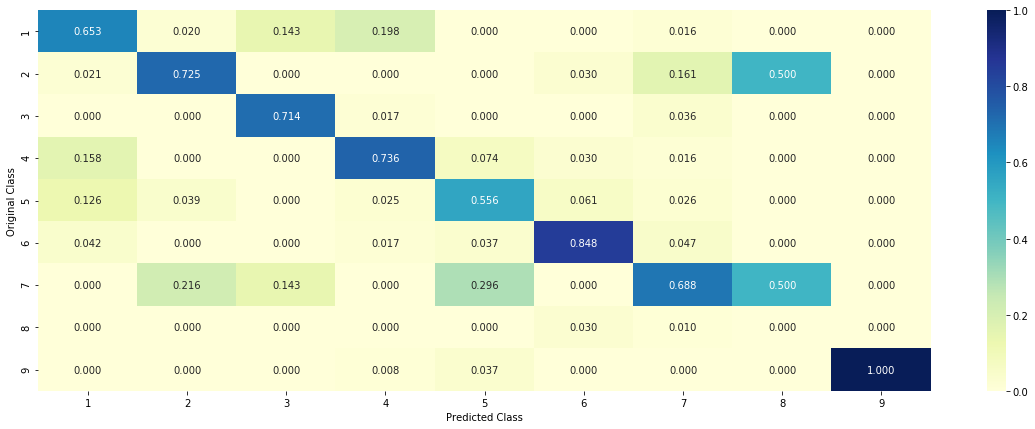

-------------------- Recall matrix (Row sum=1) --------------------


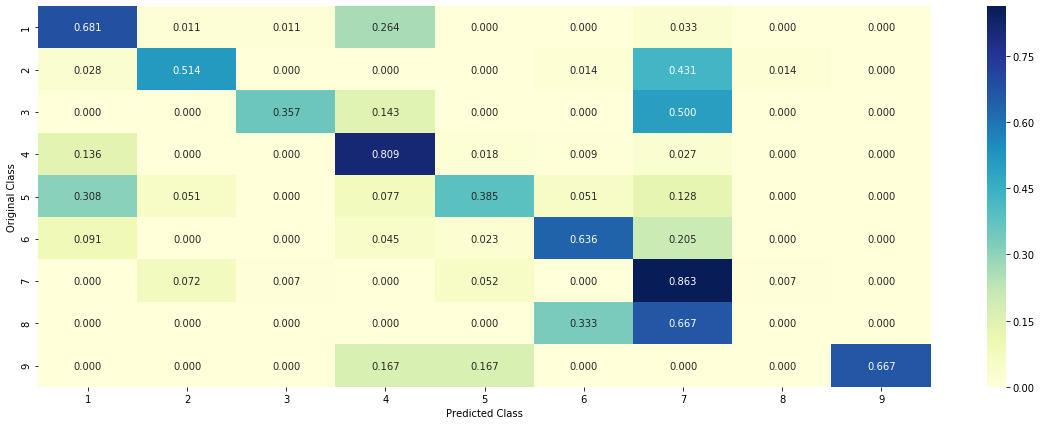

In [115]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

#### Feature Importance

In [116]:
def get_imp_feature_names(text, indices, removed_ind = []):
    word_present = 0
    tabulte_list = []
    incresingorder_ind = 0
    for i in indices:
        if i < train_gene_feature_onehotCoding.shape[1]:
            tabulte_list.append([incresingorder_ind, "Gene", "Yes"])
        elif i< 18:
            tabulte_list.append([incresingorder_ind,"Variation", "Yes"])
        if ((i > 17) & (i not in removed_ind)) :
            word = train_text_features[i]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
            tabulte_list.append([incresingorder_ind,train_text_features[i], yes_no])
        incresingorder_ind += 1
    print(word_present, "most importent features are present in our query point")
    print("-"*50)
    print("The features that are most importent of the ",predicted_cls[0]," class:")
    print (tabulate(tabulte_list, headers=["Index",'Feature name', 'Present or Not']))

testing query point and doing interpretability

In [117]:
# from tabulate import tabulate
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.1151 0.2132 0.0246 0.1141 0.0843 0.0586 0.3719 0.007  0.0112]]
Actual Class : 7
--------------------------------------------------
205 Text feature [transformation] present in test data point [True]
250 Text feature [napsin] present in test data point [True]
252 Text feature [expressing] present in test data point [True]
339 Text feature [activation] present in test data point [True]
346 Text feature [coiled] present in test data point [True]
436 Text feature [cc] present in test data point [True]
Out of the top  500  features  6 are present in query point


In [118]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.0582 0.0825 0.0107 0.5022 0.0297 0.0176 0.2889 0.0045 0.0058]]
Actual Class : 4
--------------------------------------------------
104 Text feature [lyn] present in test data point [True]
352 Text feature [1008] present in test data point [True]
355 Text feature [bsa] present in test data point [True]
390 Text feature [e3] present in test data point [True]
Out of the top  500  features  4 are present in query point


#### Without Class balancing

In [119]:
alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs))

for alpha = 1e-06
Log Loss : 1.257045677661537
for alpha = 1e-05
Log Loss : 1.1847675276991247
for alpha = 0.0001
Log Loss : 1.0132444309982993
for alpha = 0.001
Log Loss : 0.977477716671742
for alpha = 0.01
Log Loss : 1.0592497890959822
for alpha = 0.1
Log Loss : 1.3497665860103074
for alpha = 1
Log Loss : 1.5933715326984346


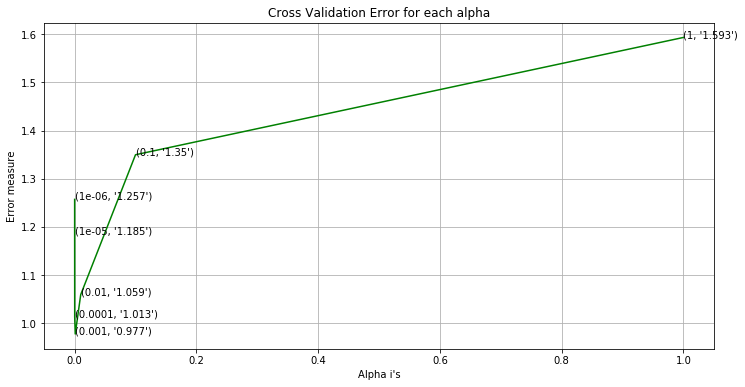

In [120]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [121]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.001 The train log loss is: 0.5551632983589977
For values of best alpha =  0.001 The cross validation log loss is: 0.977477716671742
For values of best alpha =  0.001 The test log loss is: 1.1609682950841675


Log loss : 0.977477716671742
Number of mis-classified points : 0.29887218045112784
-------------------- Confusion matrix --------------------


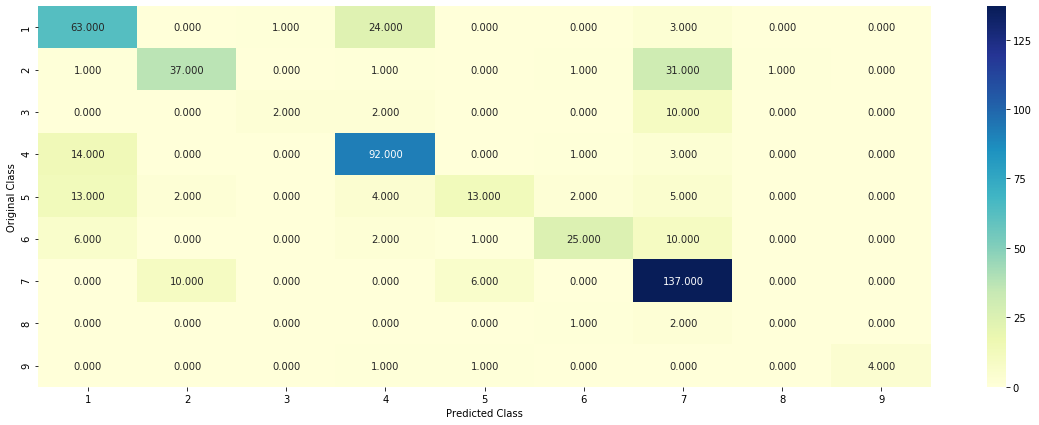

-------------------- Precision matrix (Columm Sum=1) --------------------


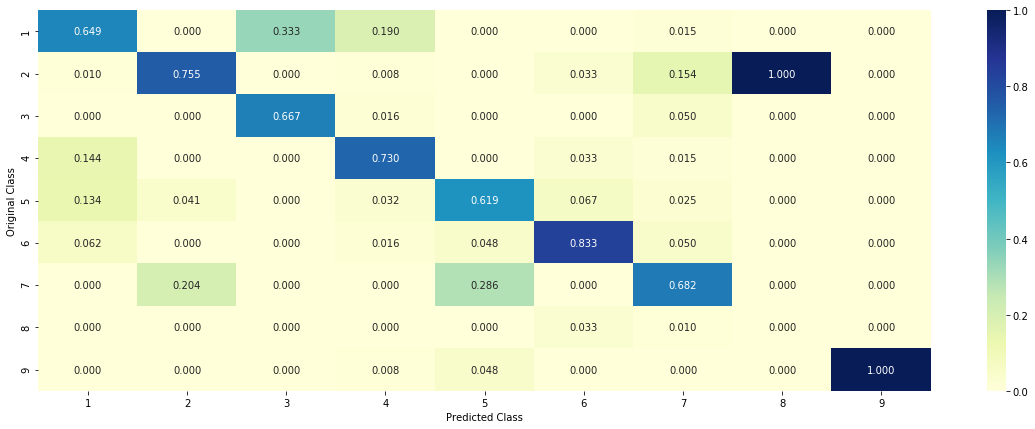

-------------------- Recall matrix (Row sum=1) --------------------


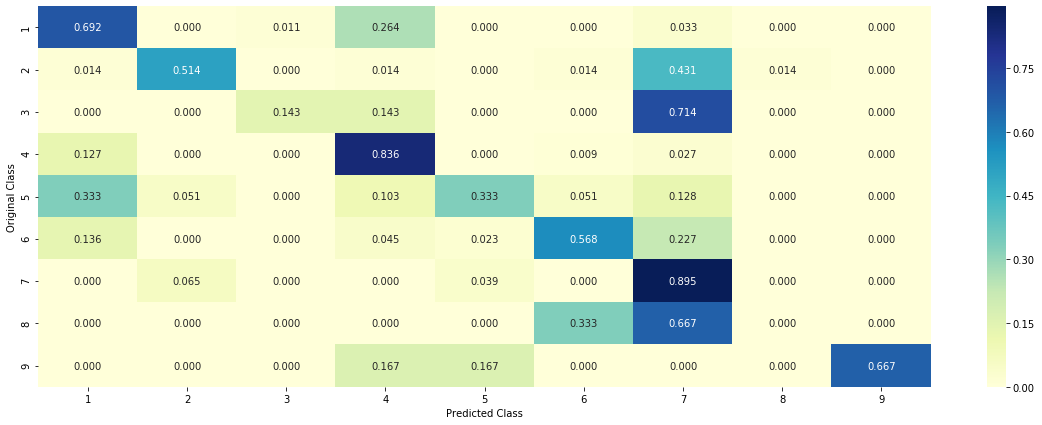

In [122]:
# testing our model with the best hyper-parameters

clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

#### Testing query point and interpretability

In [123]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.1111 0.2161 0.035  0.1037 0.0911 0.0645 0.3495 0.0099 0.0191]]
Actual Class : 7
--------------------------------------------------
286 Text feature [napsin] present in test data point [True]
288 Text feature [transformation] present in test data point [True]
357 Text feature [expressing] present in test data point [True]
457 Text feature [coiled] present in test data point [True]
Out of the top  500  features  4 are present in query point


## Linear SVM

for C = 1e-05
Log Loss : 1.20712507591133
for C = 0.0001
Log Loss : 1.1265021661547172
for C = 0.001
Log Loss : 1.0280546845336211
for C = 0.01
Log Loss : 1.0564005849200424
for C = 0.1
Log Loss : 1.2925035067262043
for C = 1
Log Loss : 1.6716216828301225
for C = 10
Log Loss : 1.6804379160806682
for C = 100
Log Loss : 1.6804379166978856


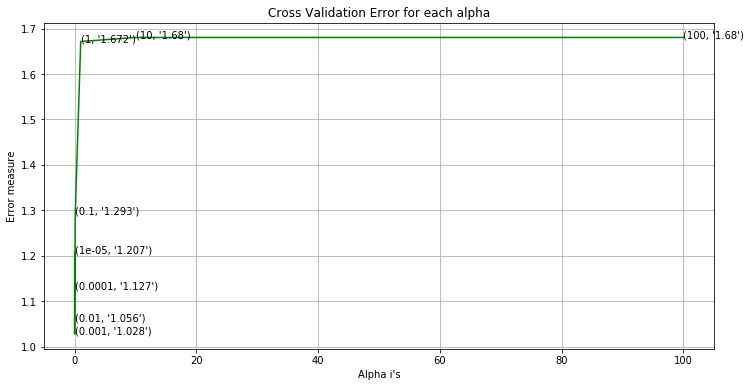

For values of best alpha =  0.001 The train log loss is: 0.5719929510761164
For values of best alpha =  0.001 The cross validation log loss is: 1.0280546845336211
For values of best alpha =  0.001 The test log loss is: 1.1902594387243255


In [124]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 1.0280546845336211
Number of mis-classified points : 0.31390977443609025
-------------------- Confusion matrix --------------------


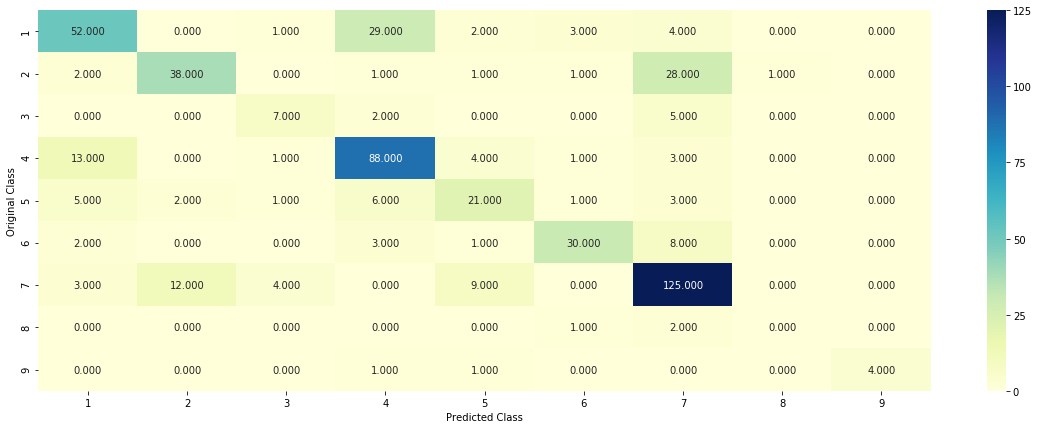

-------------------- Precision matrix (Columm Sum=1) --------------------


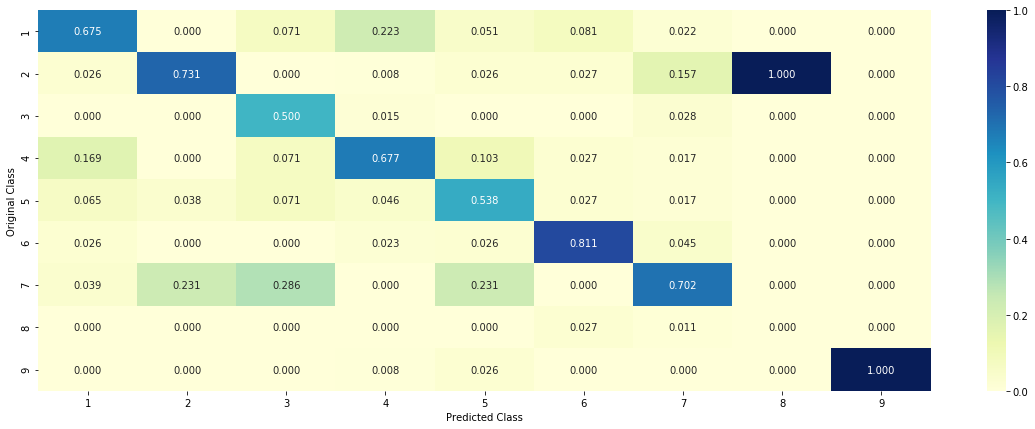

-------------------- Recall matrix (Row sum=1) --------------------


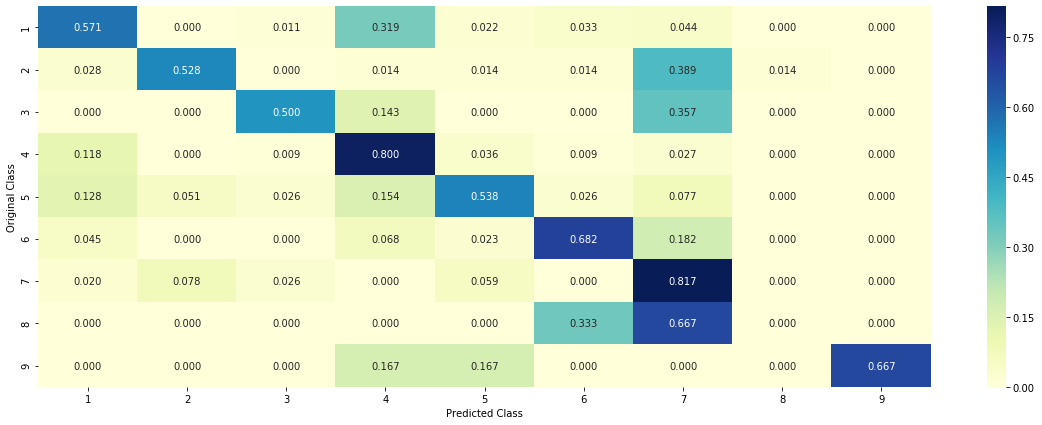

In [125]:
# Testing model with the best alpha values

clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

In [126]:
# Quering some correctly classified point

clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
# test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.1348 0.2397 0.0206 0.1059 0.0888 0.0438 0.351  0.0057 0.0098]]
Actual Class : 7
--------------------------------------------------
306 Text feature [napsin] present in test data point [True]
Out of the top  500  features  1 are present in query point


## Random Forest Classifier

#### Model with One hot encoder

In [127]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs))

for n_estimators = 100 and max depth =  5
Log Loss : 1.184497040257136
for n_estimators = 100 and max depth =  10
Log Loss : 1.1152787723246944
for n_estimators = 200 and max depth =  5
Log Loss : 1.1798678536497464
for n_estimators = 200 and max depth =  10
Log Loss : 1.10449204639764
for n_estimators = 500 and max depth =  5
Log Loss : 1.168078787794217
for n_estimators = 500 and max depth =  10
Log Loss : 1.0971403779073965
for n_estimators = 1000 and max depth =  5
Log Loss : 1.1645574983262914
for n_estimators = 1000 and max depth =  10
Log Loss : 1.093747308986693
for n_estimators = 2000 and max depth =  5
Log Loss : 1.1673971528498566
for n_estimators = 2000 and max depth =  10
Log Loss : 1.0959483434097332


In [128]:
best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best estimator =  1000 The train log loss is: 0.7001182927335365
For values of best estimator =  1000 The cross validation log loss is: 1.0937473089866927
For values of best estimator =  1000 The test log loss is: 1.16514052268805


Log loss : 1.0937473089866927
Number of mis-classified points : 0.36466165413533835
-------------------- Confusion matrix --------------------


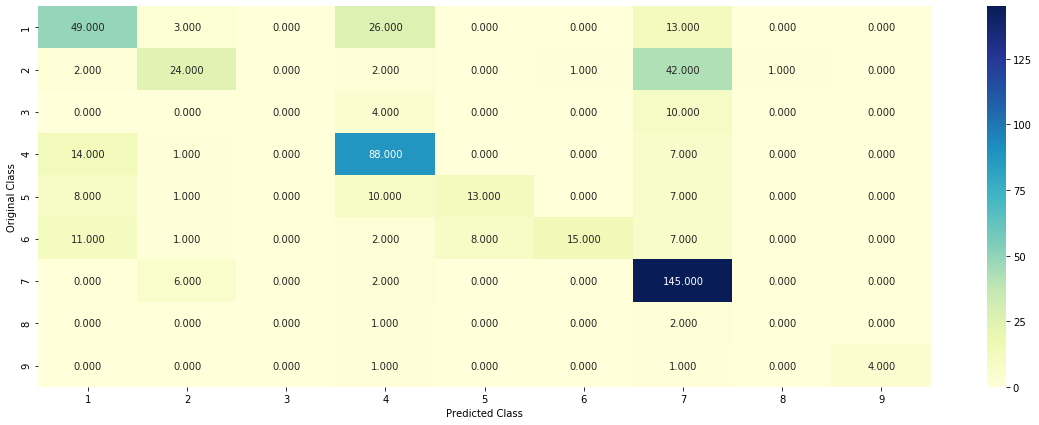

-------------------- Precision matrix (Columm Sum=1) --------------------


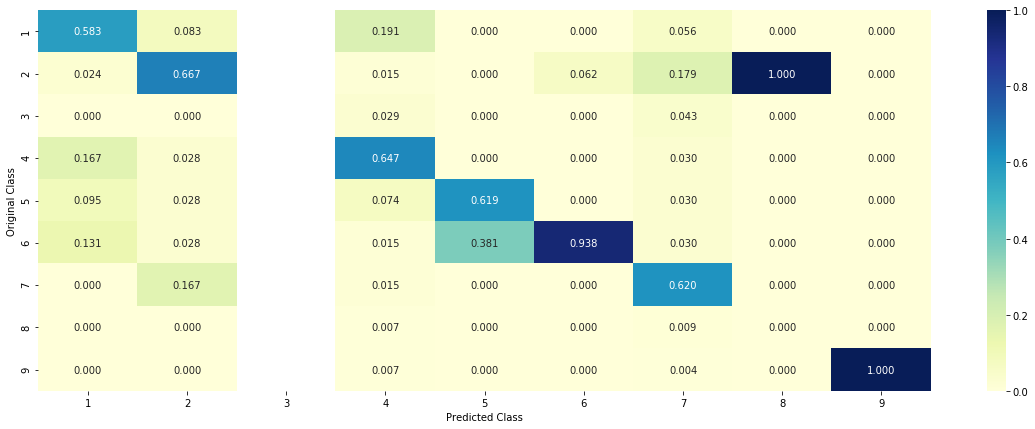

-------------------- Recall matrix (Row sum=1) --------------------


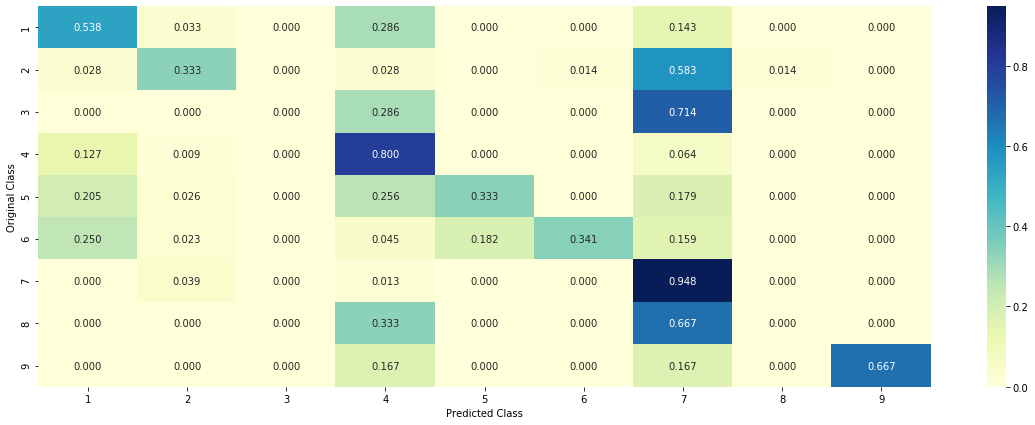

In [129]:
# testing with best hyper-parameters

clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

In [130]:
# test_point_index = 10
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.1049 0.2804 0.0242 0.1262 0.0606 0.0463 0.3428 0.0069 0.0078]]
Actual Class : 7
--------------------------------------------------
0 Text feature [kinase] present in test data point [True]
3 Text feature [inhibitors] present in test data point [True]
4 Text feature [tyrosine] present in test data point [True]
5 Text feature [activation] present in test data point [True]
6 Text feature [treatment] present in test data point [True]
7 Text feature [therapy] present in test data point [True]
9 Text feature [function] present in test data point [True]
11 Text feature [treated] present in test data point [True]
16 Text feature [phosphorylation] present in test data point [True]
19 Text feature [oncogenic] present in test data point [True]
23 Text feature [cells] present in test data point [True]
26 Text feature [kinases] present in test data point [True]
40 Text feature [cell] present in test data point [True]
50 Text feature [growth] pr

#### Model with Response Coding

In [131]:
alpha = [10,50,100,200,500,1000]
max_depth = [2,3,5,10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_responseCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_responseCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 10 and max depth =  2
Log Loss : 2.1426370060793887
for n_estimators = 10 and max depth =  3
Log Loss : 1.7166957482163805
for n_estimators = 10 and max depth =  5
Log Loss : 1.3185729213231316
for n_estimators = 10 and max depth =  10
Log Loss : 2.0246180775909144
for n_estimators = 50 and max depth =  2
Log Loss : 1.5244852202218409
for n_estimators = 50 and max depth =  3
Log Loss : 1.3653217761499
for n_estimators = 50 and max depth =  5
Log Loss : 1.3560517057036747
for n_estimators = 50 and max depth =  10
Log Loss : 1.5509182577992864
for n_estimators = 100 and max depth =  2
Log Loss : 1.411691634536868
for n_estimators = 100 and max depth =  3
Log Loss : 1.3484023318711789
for n_estimators = 100 and max depth =  5
Log Loss : 1.2230595827705075
for n_estimators = 100 and max depth =  10
Log Loss : 1.586450257592248
for n_estimators = 200 and max depth =  2
Log Loss : 1.4694601662843418
for n_estimators = 200 and max depth =  3
Log Loss : 1.4095162585989056
fo

Log loss : 1.2230595827705075
Number of mis-classified points : 0.4718045112781955
-------------------- Confusion matrix --------------------


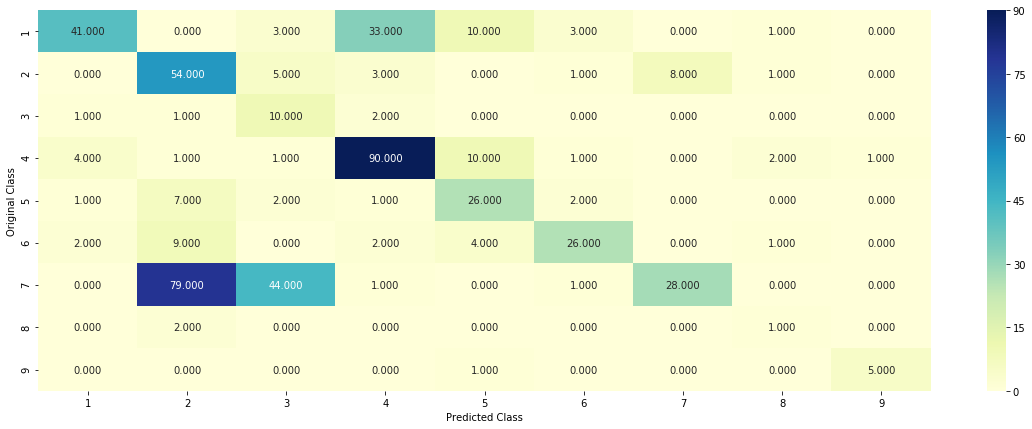

-------------------- Precision matrix (Columm Sum=1) --------------------


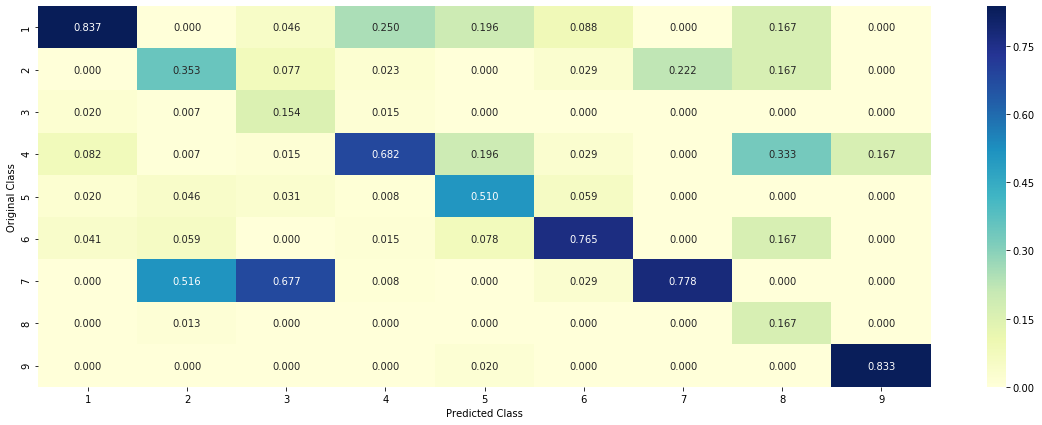

-------------------- Recall matrix (Row sum=1) --------------------


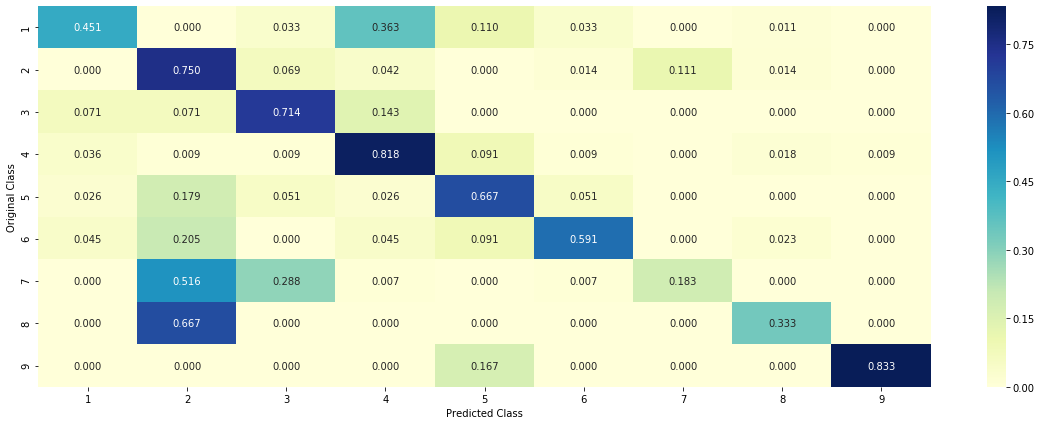

In [132]:
#testing model with the best hyper parameters

clf = RandomForestClassifier(max_depth=max_depth[int(best_alpha%4)], n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_features='auto',random_state=42)
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y,cv_x_responseCoding,cv_y, clf)

In [133]:
#Query the classified point

clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)


test_point_index = 1
no_feature = 27
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 2
Predicted Class Probabilities: [[0.0114 0.6512 0.0684 0.0121 0.0162 0.0271 0.1946 0.0114 0.0078]]
Actual Class : 7
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Text is important feature
Text is important feature
Gene is important feature
Text is important feature
Gene is important feature
Text is important feature
Variation is important feature
Text is important feature
Gene is important feature
Text is important feature
Gene is important feature
Gene is important feature
Variation is important feature
Text is important feature
Variation is important feature
Text is important feature
Gene is important feature
Text is important feature
Gene is important feature
Gene is important feature


## Stacking Model

In [134]:
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x_onehotCoding, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_onehotCoding, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.001)
clf3.fit(train_x_onehotCoding, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_x_onehotCoding, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x_onehotCoding))))
sig_clf2.fit(train_x_onehotCoding, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x_onehotCoding))))
sig_clf3.fit(train_x_onehotCoding, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_onehotCoding))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_onehotCoding, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 0.96
Support vector machines : Log Loss: 1.67
Naive Bayes : Log Loss: 1.20
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 2.178
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 2.035
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.487
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.023
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.065
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.312


Log loss (train) on the stacking classifier : 0.6318778149605339
Log loss (CV) on the stacking classifier : 1.023112618338605
Log loss (test) on the stacking classifier : 1.200164101051313
Number of missclassified point : 0.3954887218045113
-------------------- Confusion matrix --------------------


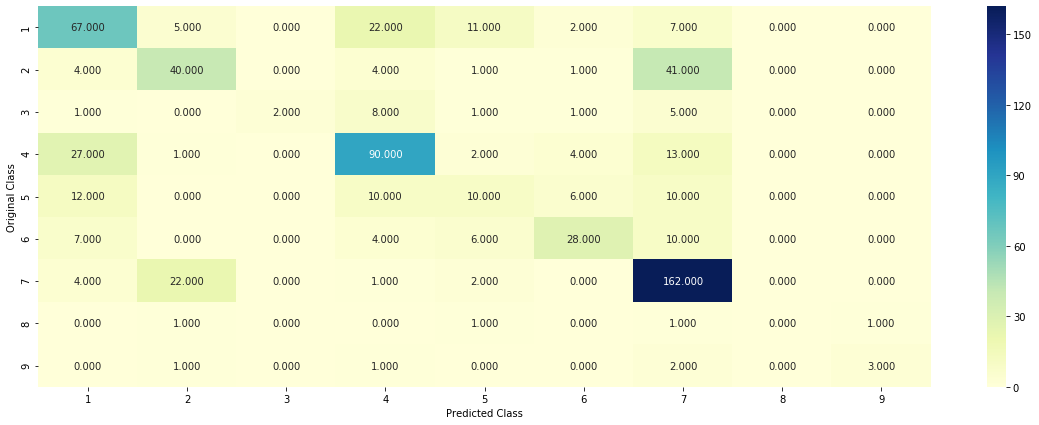

-------------------- Precision matrix (Columm Sum=1) --------------------


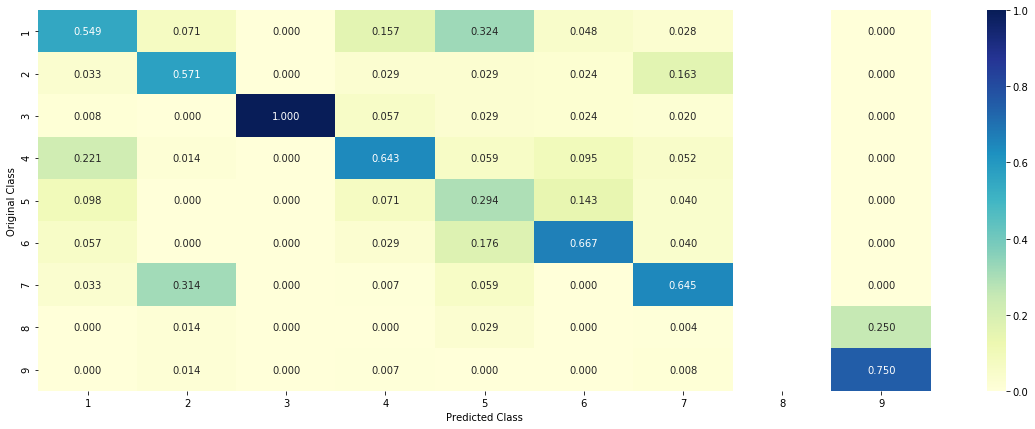

-------------------- Recall matrix (Row sum=1) --------------------


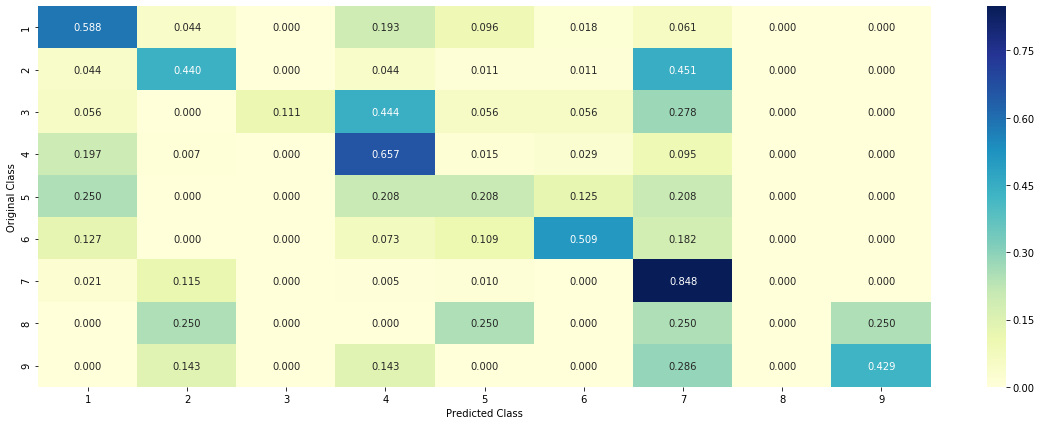

In [135]:
# testing with the best hyper parameters

lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_onehotCoding, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_onehotCoding))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_onehotCoding))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x_onehotCoding))

## Maximum Voting Classifier

Log loss (train) on the VotingClassifier : 0.8960248470607779
Log loss (CV) on the VotingClassifier : 1.1268243715969393
Log loss (test) on the VotingClassifier : 1.2481282423244873
Number of missclassified point : 0.39849624060150374
-------------------- Confusion matrix --------------------


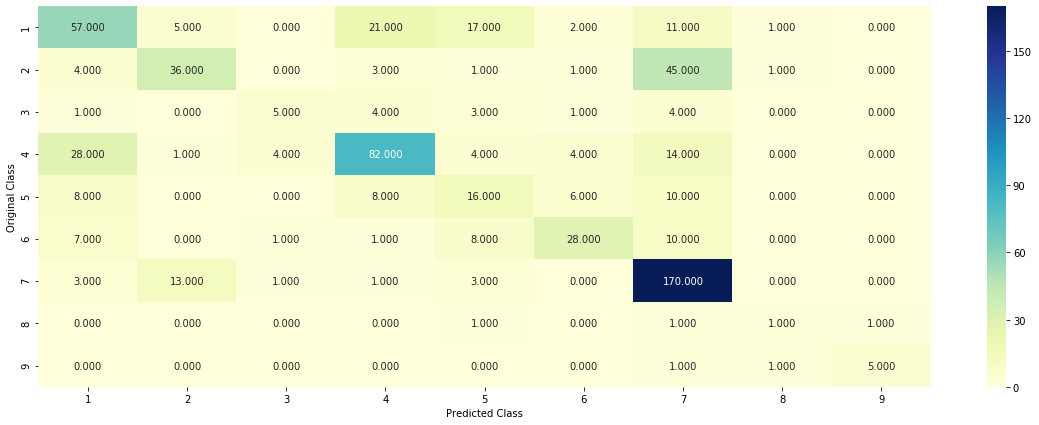

-------------------- Precision matrix (Columm Sum=1) --------------------


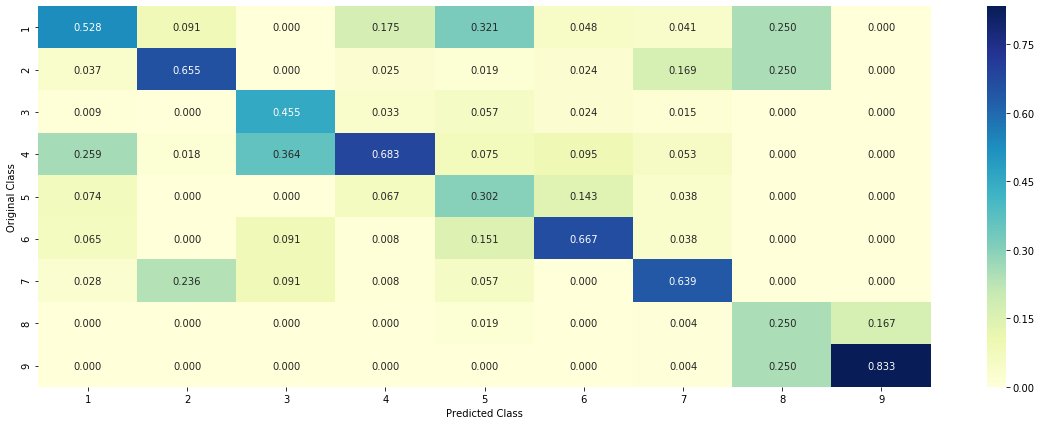

-------------------- Recall matrix (Row sum=1) --------------------


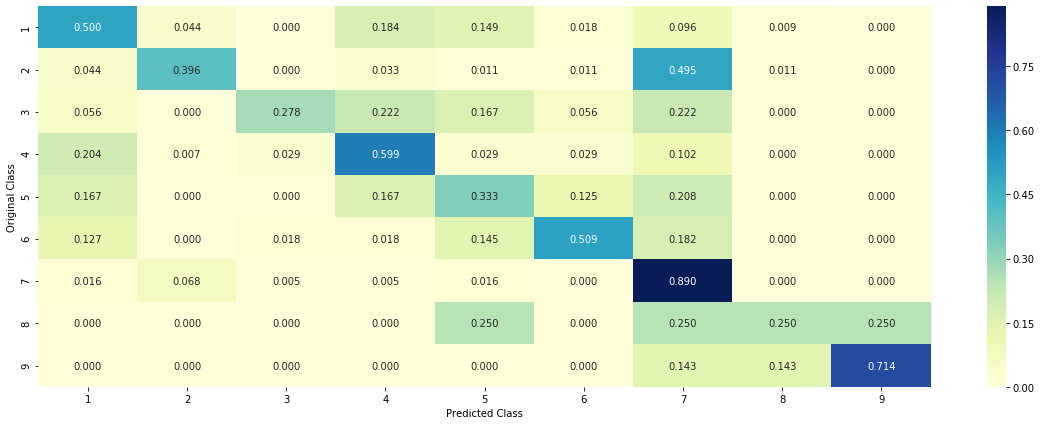

In [136]:
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], voting='soft')
vclf.fit(train_x_onehotCoding, train_y)
print("Log loss (train) on the VotingClassifier :", log_loss(train_y, vclf.predict_proba(train_x_onehotCoding)))
print("Log loss (CV) on the VotingClassifier :", log_loss(cv_y, vclf.predict_proba(cv_x_onehotCoding)))
print("Log loss (test) on the VotingClassifier :", log_loss(test_y, vclf.predict_proba(test_x_onehotCoding)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=vclf.predict(test_x_onehotCoding))